In [7]:
import feather
import time
start_time = time.time()
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gc
from imblearn.over_sampling import SMOTE
from sklearn.metrics import *
from imblearn.metrics import classification_report_imbalanced
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import GradientBoostingClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier, plot_importance
import datetime
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from collections import Counter
import configparser
import ast
import pickle
import sys
from multiprocessing import Pool, Process
# import keras
# from keras.layers import *
# from keras.models import *
# from keras.preprocessing.sequence import *
# from keras.regularizers import *
# from keras.optimizers import *
# from keras.callbacks import EarlyStopping
import warnings

config = configparser.ConfigParser()
# config.read('/home/melgazar9/Trading/TD/Scripts/Trading-Scripts/CL/scripts/CL_30min_TRAIN-MODEL.ini')

config_path = config.read('/home/melgazar9/Trading/TD/Scripts/Trading-Scripts/Multi-Product/scripts/CL/CL_10min_Multi-Product_TrainModel.ini')

print('**************** RUNNING', config['NAME']['product'], ' ****************')

train_start_date = config['PARAMS']['train_start_date']
train_end_date = config['PARAMS']['train_end_date']
val_start_date = config['PARAMS']['val_start_date']
val_end_date = config['PARAMS']['val_end_date']
test_start_date = config['PARAMS']['test_start_date']

threshold = float(config['PARAMS']['threshold'])
multiplier = float(config['PARAMS']['multiplier'])

strong_buy_actual = float(config['PARAMS']['strong_buy_actual'])
med_buy_actual = float(config['PARAMS']['med_buy_actual'])
no_trade_actual = float(config['PARAMS']['no_trade_actual'])
med_sell_actual = float(config['PARAMS']['med_sell_actual'])
strong_sell_actual = float(config['PARAMS']['strong_sell_actual'])
stop_actual = float(config['PARAMS']['stop_actual'])

strong_buy_HL = float(config['PARAMS']['strong_buy_HL'])
med_buy_HL = float(config['PARAMS']['med_buy_HL'])
no_trade_HL = float(config['PARAMS']['no_trade_HL'])
med_sell_HL = float(config['PARAMS']['med_sell_HL'])
strong_sell_HL = float(config['PARAMS']['strong_sell_HL'])
stop_HL = float(config['PARAMS']['stop_HL'])

strong_cap_actual = float(config['PARAMS']['strong_cap_actual'])
med_cap_actual = float(config['PARAMS']['med_cap_actual'])
strong_cap_HL = float(config['PARAMS']['strong_cap_HL'])
med_cap_HL = float(config['PARAMS']['med_cap_actual'])

min_prob0 = float(config['PARAMS']['min_prob0'])
min_prob1 = float(config['PARAMS']['min_prob1'])
min_prob3 = float(config['PARAMS']['min_prob3'])
min_prob4 = float(config['PARAMS']['min_prob4'])

min_prob_override0 = float(config['PARAMS']['min_prob_override0'])
min_prob_override1 = float(config['PARAMS']['min_prob_override1'])
min_prob_override3 = float(config['PARAMS']['min_prob_override3'])
min_prob_override4 = float(config['PARAMS']['min_prob_override4'])

Actual_Move = config['PARAMS']['Actual_Move_Name']
Actual_HighMove = config['PARAMS']['Actual_HighMove_Name']
Actual_LowMove = config['PARAMS']['Actual_LowMove_Name']


raw_model_hyperparams_ACTUAL = ast.literal_eval(config['PARAMS']['raw_model_hyperparams_ACTUAL'])
smote_model_hyperparams_ACTUAL = ast.literal_eval(config['PARAMS']['smote_model_hyperparams_ACTUAL'])

raw_model_hyperparams_HL = ast.literal_eval(config['PARAMS']['raw_model_hyperparams_HL'])
smote_model_hyperparams_HL = ast.literal_eval(config['PARAMS']['smote_model_hyperparams_HL'])


round_trip_fee = float(config['PARAMS']['round_trip_fee'])


if config['PARAMS']['HL_ON'] == 'TRUE':
    HL_ON = True
else:
    HL_ON = False

if config['PARAMS']['ACTUAL_ON'] == 'TRUE':
    ACTUAL_ON = True
else:
    ACTUAL_ON = False




if config['PARAMS']['read_feather'] == 'FALSE':
    df = pd.read_csv(config['PATH']['filename'])
elif config['PARAMS']['read_feather'] == 'TRUE':
    # df = feather.read_dataframe(config['PATH']['filename'], nthreads=32)
    print('Reading Feather File')
    df = feather.read_dataframe(config['PATH']['filename'])
df.set_index('Datetime', inplace=True)
df.index = pd.to_datetime(df.index)
df.index = df.index.tz_localize('utc').tz_convert('US/Central')
df.dropna(axis=0, inplace=True)



df[Actual_Move] = df[[config['NAME']['product'][0:2] + '_Prev' + Actual_Move.strip(config['NAME']['product'][0:2]+'_Actual').strip(config['NAME']['product'][0:2])]].resample(config['NAME']['product'][-6:-1]).first().rename(columns={config['NAME']['product'][0:2] + '_Prev' + Actual_Move.strip('Actual') : Actual_Move}).shift(-1)
df[Actual_HighMove] = df[[config['NAME']['product'][0:2] + '_Prev' + Actual_HighMove.strip(config['NAME']['product'][0:2]+'_Actual').strip(config['NAME']['product'][0:2])]].resample(config['NAME']['product'][-6:-1]).first().rename(columns={config['NAME']['product'][0:2] + '_Prev' + Actual_HighMove.strip('Actual') : Actual_HighMove}).shift(-1)
df[Actual_LowMove] = df[[config['NAME']['product'][0:2] + '_Prev' + Actual_LowMove.strip(config['NAME']['product'][0:2]+'_Actual').strip(config['NAME']['product'][0:2])]].resample(config['NAME']['product'][-6:-1]).first().rename(columns={config['NAME']['product'][0:2] + '_Prev' + Actual_LowMove.strip('Actual'): Actual_LowMove}).shift(-1)


# Create categorical feature for Overnight_or_Intraday
df.loc[df.between_time('06:00:00','15:00:00', include_start=False).index, 'Overnight_or_Intraday'] = 1
df['Overnight_or_Intraday'].fillna(0, inplace=True)


class CalcTarget():

    def __init__(self, df, strong_buy, med_buy, no_trade, med_sell, strong_sell, threshold, stop):

        self.df = df
        self.strong_buy = strong_buy
        self.med_buy = med_buy
        self.no_trade = no_trade
        self.med_sell = med_sell
        self.strong_sell = strong_sell
        self.threshold = threshold # to prevent data errors
        self.stop = stop

    def calc_target_actual(self):

        super().__init__()

#         self.df[Actual_Move] = self.df['Prev' + Actual_Move.strip('Actual')].shift(-1)

        lst = []
        i=0
        while i < len(df):
            if np.isnan(self.df[Actual_LowMove][i]) or np.isnan(self.df[Actual_HighMove][i]):
                i+=1

            # strong buy
            elif self.df[Actual_Move][i] >= self.strong_buy and self.df[Actual_Move][i] <= self.threshold and self.df[Actual_LowMove][i] > (-1)*self.stop:
                lst.append(4)
                i+=1

            # medium buy
            elif self.df[Actual_Move][i] >= self.med_buy and self.df[Actual_Move][i] <= self.strong_buy and self.df[Actual_LowMove][i] > (-1)*self.stop:
                lst.append(3)
                i+=1

            # medium sell
            elif self.df[Actual_Move][i] <= (-1) * self.med_sell and self.df[Actual_Move][i] >= (-1) * self.strong_sell and self.df[Actual_LowMove][i] < self.stop:
                lst.append(1)
                i+=1

            # strong sell
            elif self.df[Actual_Move][i] <= (-1) * self.strong_sell and self.df[Actual_Move][i] >= (-1) * self.threshold and self.df[Actual_LowMove][i] < self.stop:
                lst.append(0)
                i+=1

            # no trade
            else:
                lst.append(2)
                i+=1

#         return pd.DataFrame(lst, index=self.df.index).rename(columns={0:'Target_Actual'})
        return pd.DataFrame(lst, index=self.df[[Actual_Move]].dropna().index).rename(columns={0:'Target_Actual'})


    def calc_target_HL(self):

        # stop means how much heat I am willing to take per trade
        # i.e. if the move went up in my favor $50 but I took $1000 worth of heat that isn't good
        # hm stands for high move, lm stands for low move

        lst = []

        i = 0
        while i < len(self.df):
            if np.isnan(self.df[Actual_LowMove][i]) or np.isnan(self.df[Actual_HighMove][i]):
                i+=1
            # if ActualHM >= buy signal AND ActualLM doesn't go below stop
            elif self.df[Actual_HighMove][i] >= self.strong_buy and self.df[Actual_LowMove][i] >= (-1)*self.stop:
                lst.append(4)
                i+=1
            elif self.df[Actual_LowMove][i] <= (-1)*self.strong_sell and self.df[Actual_HighMove][i] <= self.stop:
                lst.append(0)
                i+=1
            elif self.df[Actual_HighMove][i] >= self.med_buy and self.df[Actual_LowMove][i] >= (-1)*self.stop:
                lst.append(3)
                i+=1
            elif self.df[Actual_LowMove][i] <= (-1)*self.med_sell and self.df[Actual_HighMove][i] <= self.stop:
                lst.append(1)
                i+=1
            else:
                lst.append(2)
                i+=1
        print(len(lst))

#         return pd.DataFrame(lst, index=self.df.resample('60min').first().index).rename(columns={0:'Target_HL'})
        return pd.DataFrame(lst, index=self.df[[Actual_Move]].dropna().index).rename(columns={0:'Target_HL'})


# print('Calculating Target...')
target_actual = CalcTarget(df, strong_buy=strong_buy_actual, med_buy=med_buy_actual, no_trade=no_trade_actual,
                            med_sell=med_sell_actual, strong_sell=strong_sell_actual, threshold=threshold,
                            stop=stop_actual).calc_target_actual()

target_HL = CalcTarget(df, strong_buy=strong_buy_HL, med_buy=med_buy_HL, no_trade=no_trade_HL,
                        med_sell=med_sell_HL, strong_sell=strong_sell_HL, threshold=threshold,
                        stop=stop_HL).calc_target_HL()

print(target_actual['Target_Actual'].value_counts())
print(target_HL['Target_HL'].value_counts())

for i in range(int(config['PARAMS']['min_target_lookback']), int(config['PARAMS']['max_target_lookback']), int(config['PARAMS']['target_lookback_increment'])):
    target_HL['Prev_Target_HL' + str(i)] = target_HL['Target_HL'].shift(i)

for i in range(int(config['PARAMS']['min_target_lookback']), int(config['PARAMS']['max_target_lookback']), int(config['PARAMS']['target_lookback_increment'])):
    target_HL['Prev_Target_HL' + str(i)] = target_HL['Target_HL'].shift(i)

target_HL = target_HL.fillna(2).astype('int')
target_actual = target_actual.fillna(2).astype('int')

df['Target_Actual'] = target_actual['Target_Actual']
df['Target_HL'] = target_HL['Target_HL']



# Set categorical variables in an array
cat_vars = ['Year', 'Month', 'Week', 'Day', 'DayofWeek', 'DayofYear', 'IsMonthEnd',
            'IsMonthStart', 'IsQuarterEnd', 'IsQuarterStart', 'IsYearEnd', 'IsHoliday',
            'IsYearStart', 'Overnight_or_Intraday', 'Hour', 'Quarter']

cat_vars = cat_vars + [i for i in df.columns if i.endswith('Binned') or i.endswith('Opinion') or i.startswith('PrevTarget')]
cont_vars = [i for i in df.columns if not i in cat_vars]

print(len(df.columns) == len(cat_vars)+len(cont_vars)) # must be True!

joined = df[train_start_date:val_end_date][cat_vars+cont_vars].copy()
joined_test = df[test_start_date:][cat_vars+cont_vars].copy()
print(df)
# for v in cat_vars:
#     joined[v] = joined[v].astype('category').cat.as_ordered()
#     joined_test[v] = joined_test[v].astype('category').cat.as_ordered()

# Create categorical variables for joined_test set on datetime-type columns: Year, Month, etc..
# 'Year', 'Month', 'Week', 'Day', 'DayofWeek', 'DayofYear', 'Hour', 'Quarter'
print('Filling Categories...')
joined_test['Year'] = joined_test.index.year.astype('category')
joined_test['Month'] = joined_test.index.month.astype('category')
joined_test['Week'] = joined_test.index.week.astype('category')
joined_test['Day'] = joined_test.index.day.astype('category')
joined_test['DayofWeek'] = joined_test.index.dayofweek.astype('category')
joined_test['DayofYear'] = joined_test.index.dayofyear.astype('category')
joined_test['Hour'] = joined_test.index.hour.astype('category')
joined_test['Quarter'] = joined_test.index.quarter.astype('category')

# Fill continuous variables using backfill
for v in cont_vars:
    joined[v] = joined[v].bfill().astype('float32')
    joined_test[v] = joined_test[v].bfill().astype('float32')
# print(joined.isnull().any()[joined.isnull().any()!=False], '\n')
# print(joined_test.isnull().any()[joined_test.isnull().any()!=False])
# print(joined.get_dtype_counts())
# print(joined_test.get_dtype_counts())

print('Concatenating joined and joined_test...')
df = pd.concat([joined, joined_test], axis=0)


# One-hot encode categorical features
print('Getting Dummies...')
df = pd.get_dummies(df, columns=[i for i in cat_vars], drop_first=True)
df.rename(columns={'Overnight_or_Intraday_1.0':'Overnight_or_Intraday'}, inplace=True)
cat_vars = [i for i in df.columns if not i in cont_vars]

print('Converting dtypes...')
for col in cat_vars:
    df[col] = df[col].astype('category').cat.as_ordered()

for col in cont_vars:
    df[col] = df[col].astype('float32')

#################################################################
#       TRAIN TEST SPLIT FOR ACTUAL-MOVE and HL STRATEGIES
#################################################################

def time_series_split(train_start_date, train_end_date, val_start_date, val_end_date, test_start_date, HL):

    X = df.drop([Actual_Move, Actual_HighMove, Actual_LowMove, 'Target_Actual', 'Target_HL'], axis=1)
    y_actual = df['Target_Actual']
    y_HL = df['Target_HL']

    X.sort_index(inplace=True)
    y_actual.sort_index(inplace=True)
    y_HL.sort_index(inplace=True)

    y_HL.fillna(2, inplace=True)
    y_actual.fillna(2, inplace=True)

    X_train = X[train_start_date:train_end_date]
    X_val = X[val_start_date:val_end_date]
    X_test = X[test_start_date:]

    y_train_actual = y_actual[train_start_date:train_end_date]
    y_val_actual = y_actual[val_start_date:val_end_date]
    y_test_actual = y_actual[test_start_date:]

    y_train_HL = y_HL[train_start_date:train_end_date]
    y_val_HL = y_HL[val_start_date:val_end_date]
    y_test_HL = y_HL[test_start_date:]

    y_test_actual.fillna(2, inplace=True)
    y_test_HL.fillna(2, inplace=True)


    if config['PARAMS']['HL_ON']=='FALSE':
        print(X_train.shape, X_val.shape, X_test.shape, y_train_actual.shape, y_val_actual.shape, y_test_actual.shape)
        return X_train, X_val, X_test, y_train_actual, y_val_actual, y_test_actual

    elif config['PARAMS']['HL_ON']=='TRUE':
        print(X_train.shape, X_val.shape, X_test.shape, y_train_HL.shape, y_val_HL.shape, y_test_HL.shape)
        return X_train, X_val, X_test, y_train_HL, y_val_HL, y_test_HL


print('Time Series Split...')
# Actual
if config['PARAMS']['ACTUAL_ON'] == 'TRUE':
    X_train, X_val, X_test, y_train_actual, y_val_actual, y_test_actual = time_series_split(train_start_date=train_start_date, train_end_date=train_end_date,
                                                                                            val_start_date=val_start_date, val_end_date=val_end_date,
                                                                                            test_start_date=test_start_date, HL=False)
# HL
if config['PARAMS']['HL_ON'] == 'TRUE':
    X_train, X_val, X_test, y_train_HL, y_val_HL, y_test_HL = time_series_split(train_start_date=train_start_date, train_end_date=train_end_date,
                                                                                val_start_date=val_start_date, val_end_date=val_end_date,
                                                                                test_start_date=test_start_date, HL=True)
print(X_train.get_dtype_counts(), X_val.get_dtype_counts(), X_test.get_dtype_counts())

cont_vars = [i for i in cont_vars if not i.startswith('Target') and not i.startswith('Actual')]

# Scale Data
if config['PARAMS']['scale'] == 'TRUE':

    print('Scaling Data...')
    scaler = MinMaxScaler().fit(np.array(X_train))

    X_train_scaled = pd.DataFrame(scaler.transform(X_train), index=X_train.index, columns=X_train.columns)
    X_val_scaled = pd.DataFrame(scaler.transform(X_val), index=X_val.index, columns=X_val.columns)
    X_test_scaled = pd.DataFrame(scaler.transform(X_test), index=X_test.index, columns=X_test.columns)

    # for col in df.select_dtypes('uint8').columns:
    for col in cat_vars:
        #print(col)
        X_train_scaled[col] = X_train_scaled[col].astype('category').cat.as_ordered()
        X_val_scaled[col] = X_val_scaled[col].astype('category').cat.as_ordered()
        X_test_scaled[col] = X_test_scaled[col].astype('category').cat.as_ordered()

    for col in cont_vars:
        X_train_scaled[col] = X_train_scaled[col].astype('float32')
        X_val_scaled[col] = X_val_scaled[col].astype('float32')
        X_test_scaled[col] = X_test_scaled[col].astype('float32')

if config['PARAMS']['one_hot_targets'] == 'TRUE':
    print('Converting categorical targets to one-hot encoding targets')
    y_train_oh_actual = keras.utils.to_categorical(y_train_actual, num_class=5)
    y_val_oh_actual = keras.utils.to_categorical(y_val_actual, num_class=5)
    y_test_oh_actual = keras.utils.to_categorical(y_test_actual, num_class=5)

    y_train_oh_HL = keras.utils.to_categorical(y_train_HL, num_class=5)
    y_val_oh_HL = keras.utils.to_categorical(y_val_HL, num_class=5)
    y_test_oh_HL = keras.utils.to_categorical(y_test_HL, num_class=5)

**************** RUNNING CL_Multi-Product_10min_  ****************
13121
2    11046
1      730
3      704
0      343
4      298
Name: Target_Actual, dtype: int64
2    10112
1     1194
3     1147
0      361
4      307
Name: Target_HL, dtype: int64
True
                           CL_Prev10minMove  CL_Prev10minRange  \
Datetime                                                         
2018-07-19 19:00:00-05:00              0.02               0.04   
2018-07-19 19:10:00-05:00              0.13               0.19   
2018-07-19 19:20:00-05:00              0.06               0.11   
2018-07-19 19:30:00-05:00             -0.06               0.07   
2018-07-19 19:40:00-05:00              0.03               0.06   
2018-07-19 19:50:00-05:00             -0.02               0.08   
2018-07-19 20:00:00-05:00              0.01               0.11   
2018-07-19 20:10:00-05:00              0.11               0.17   
2018-07-19 20:20:00-05:00             -0.12               0.13   
2018-07-19 20:30:00-05

Concatenating joined and joined_test...
Getting Dummies...
Converting dtypes...
Time Series Split...
(11146, 5384) (230, 5384) (1856, 5384) (11146,) (230,) (1856,)
category     203
float32     5181
dtype: int64 category     203
float32     5181
dtype: int64 category     203
float32     5181
dtype: int64


In [8]:
##################################################################
#                       MACHINE LEARNING
##################################################################

class TrainModel():

    def __init__(self, model, X_train_fit, y_train_fit, X_val_fit, y_val_fit,
                 X_test_unseen, y_test_unseen, need_cont_vars, plot_importances=True):

        self.model = model
        self.X_train_fit = X_train_fit
        self.y_train_fit = y_train_fit
        self.X_val_fit = X_val_fit
        self.y_val_fit = y_val_fit
        self.X_test_unseen = X_test_unseen
        self.y_test_unseen = y_test_unseen
        self.need_cont_vars = need_cont_vars
        self.plot_importances = plot_importances


    def plot_feature_importances_traditional(self):

        super().__init__()

        features = self.X_train_fit.columns
        importances = self.model.feature_importances_
        indices = np.argsort(importances)

        plt.figure(figsize=(30, 150))
        plt.title('Feature Importances')
        plt.barh(y=range(len(indices)), width=importances[indices], height=.5, color='c', align='center')
        plt.yticks(ticks=range(len(indices)), labels=[features[i] for i in indices])
        plt.xlabel('Relative Importance')
        plt.show()

        return

    def train_traditional_ML_model(self):

        super().__init__()

        if self.need_cont_vars == True:
            self.X_train_fit = self.X_train_fit.astype('float32')
            self.X_val_fit = self.X_val_fit.astype('float32')
            self.X_test_unseen = self.X_test_unseen.astype('float32')


        try:
            self.model.fit(self.X_train.fit, self.y_train_fit, eval_set={self.X_val_fit, self.y_val_fit},
                           early_stopping_rounds=int(config['PARAMS']['early_stopping_rounds']),
                           eval_metric=ast.literal_eval(config['PARAMS']['eval_metric']))
        except:
            self.model.fit(self.X_train_fit, self.y_train_fit)

        print('Train Accuracy:', accuracy_score(self.model.predict(self.X_train_fit), self.y_train_fit))
        print('Val Accuracy:', accuracy_score(self.model.predict(self.X_val_fit), self.y_val_fit))
        print('Test Accuracy:', accuracy_score(self.model.predict(self.X_test_unseen), self.y_test_unseen))

        print('Train F1:', f1_score(self.model.predict(self.X_train_fit), self.y_train_fit, average='weighted'))
        print('Val F1:', f1_score(self.model.predict(self.X_val_fit), self.y_val_fit, average='weighted'))
        print('Test F1:', f1_score(self.model.predict(self.X_test_unseen), self.y_test_unseen, average='weighted'))

        print('Train:', classification_report_imbalanced(self.model.predict(self.X_train_fit), self.y_train_fit))
        print('Val:', classification_report_imbalanced(self.model.predict(self.X_val_fit), self.y_val_fit))
        print('Test:', classification_report_imbalanced(self.model.predict(self.X_test_unseen), self.y_test_unseen))

        if self.plot_importances == True:
            self.plot_feature_importances_traditional()

        return self.model

class CalcResults():

    def __init__(self, model, X, y, predictions, stop, strong_cap, med_cap, multiplier, need_cont_vars, HL, NN=False):

        self.model = model
        self.X = X
        self.y = y
        self.predictions = predictions
        self.stop = stop
        self.strong_cap = strong_cap
        self.med_cap = med_cap
        self.multiplier = multiplier
        self.need_cont_vars = need_cont_vars
        self.HL = HL
        self.NN = NN

    def calc_predictions(self):

        # Calculates which class to predict based on the predicted probability for decision making
        super().__init__()
        probs = self.model.predict_proba(self.X)

        lst=[]

        # for p in probs:
        #
        #     if p[2] == max(p): # if no trade is max probaility
        #         lst.append(2)
        #
        #     elif (p[0] >= min_prob0) and (p[0] >= max(p)): # if strong sell is max probability and >= min_prob_threshold
        #         if p[1] == sorted(p)[-2]: # if med_sell is the second highest probability
        #             lst.append(0)
        #         # elif (p[0] - sorted(p)[-2]) >= float(config['PARAMS']['min_prob_diff']): # strong sell - second highest probability which isn't med_sell (difference)
        #         #     lst.append(2)
        #         else:
        #             lst.append(2)
        #
        #     elif (p[1] >= min_prob1) and (p[1] >= max(p)): # if med sell is max probability and >= min_prob_threshold
        #         if p[0] == sorted(p)[-2]:
        #             lst.append(1)
        #         # elif (p[1] - sorted(p)[-2] >= float(config['PARAMS']['min_prob_diff'])):
        #         #     lst.append(2)
        #         else:
        #             lst.append(2)
        #
        #     elif (p[3] >= min_prob3) and (p[3] >= max(p)): # if med buy is max probability and >= min_prob_threshold
        #         if p[4] == sorted(p)[-2]:
        #             lst.append(3)
        #         # elif (p[3] - sorted(p)[-2] >= float(config['PARAMS']['min_prob_diff'])):
        #         #     lst.append(2)
        #         else:
        #             lst.append(2)
        #
        #     elif (p[4] >= min_prob4) and (p[4] >= max(p)): # if strong buy is max probability and >= min_prob_threshold
        #         if (p[3] == sorted(p)[-2]): # med_buy is second highest probability
        #             lst.append(4)
        #         # elif (p[4] - sorted(p)[-2] >= float(config['PARAMS']['min_prob_diff'])):
        #         #     lst.append(2)
        #         else:
        #             lst.append(2)
        #
        #     else:
        #         lst.append(2)

        for p in probs:

            if p[2] == max(p): # if no trade is max probaility
                lst.append(2)

            elif (p[0] >= min_prob0) and (p[0] >= max(p)): # if strong sell is max probability and >= min_prob_threshold
                if config['PARAMS']['PredProb_OrderedSell_ON'] == 'TRUE': # ON means secodn highest probability for sell must be med_sell or strong_sell.. the buy/sell probabilities (signals) can't contradict each other!
                    if p[1] == sorted(p)[-2]: # if med_sell is the second highest probability
                        lst.append(0)
                    # elif (p[0] - sorted(p)[-2]) >= float(config['PARAMS']['min_prob_diff']): # strong sell - second highest probability which isn't med_sell (difference)
                    #     lst.append(2)
                    elif config['PARAMS']['PredProb_OVERRIDE_ON'] == 'TRUE':
                        if p[0] >= min_prob_override0:
                            lst.append(0)
                        else:
                            lst.append(2)
                    else:
                        lst.append(2)

                elif config['PARAMS']['PredProb_OrderedSell_ON'] == 'FALSE':
                    lst.append(0)


            elif (p[1] >= min_prob1) and (p[1] >= max(p)): # if med sell is max probability and >= min_prob_threshold
                if config['PARAMS']['PredProb_OrderedSell_ON'] == 'TRUE':
                    if p[0] == sorted(p)[-2]: # if strong_sell is the second highest probability
                        lst.append(1)
                    # elif (p[1] - sorted(p)[-2] >= float(config['PARAMS']['min_prob_diff'])):
                    #     lst.append(2)
                    elif config['PARAMS']['PredProb_OVERRIDE_ON'] == 'TRUE':
                        if p[1] >= min_prob_override1:
                            lst.append(1)
                        else:
                            lst.append(2)
                    else:
                        lst.append(2)

                elif config['PARAMS']['PredProb_OrderedSell_ON'] == 'FALSE':
                    lst.append(1)

            elif (p[3] >= min_prob3) and (p[3] >= max(p)): # if med buy is max probability and >= min_prob_threshold
                if config['PARAMS']['PredProb_OrderedBuy_ON'] == 'TRUE':
                    if p[4] == sorted(p)[-2]: # if strong_buy is the second highest probability
                        lst.append(3)
                    # elif (p[3] - sorted(p)[-2] >= float(config['PARAMS']['min_prob_diff'])):
                    #     lst.append(2)
                    elif config['PARAMS']['PredProb_OVERRIDE_ON'] == 'TRUE':
                        if p[3] >= min_prob_override3:
                            lst.append(3)
                        else:
                            lst.append(2)
                    else:
                        lst.append(2)
                elif config['PARAMS']['PredProb_OrderedBuy_ON'] == 'FALSE':
                    lst.append(3)

            elif (p[4] >= min_prob4) and (p[4] >= max(p)): # if strong buy is max probability and >= min_prob_threshold
                if config['PARAMS']['PredProb_OrderedBuy_ON'] == 'TRUE':
                    if (p[3] == sorted(p)[-2]): # med_buy is second highest probability
                        lst.append(4)
                    # elif (p[4] - sorted(p)[-2] >= float(config['PARAMS']['min_prob_diff'])):
                    #     lst.append(2)
                    elif config['PARAMS']['PredProb_OVERRIDE_ON'] == 'TRUE':
                        if p[4] >= min_prob_override4:
                            lst.append(4)
                        else:
                            lst.append(2)
                    else:
                        lst.append(2)
                elif config['PARAMS']['PredProb_OrderedBuy_ON'] == 'FALSE':
                    lst.append(4)

            else:
                lst.append(2)

        return lst

    def initialize_df(self):

        super().__init__()

        if self.need_cont_vars == True:
            self.X = self.X.astype('float32')
        print(self.X.get_dtype_counts())

        if config['PARAMS']['PredProb_ON'] == 'FALSE':
            pred = pd.DataFrame(self.model.predict(self.X), index=self.X.index).rename(columns={0:self.predictions})
        elif config['PARAMS']['PredProb_ON'] == 'TRUE':
            pred = pd.DataFrame(self.calc_predictions(), index=self.X.index).rename(columns={0:self.predictions})

        if self.HL == False:
            results = pd.concat([pd.DataFrame(self.y, index=self.X.index), pred], axis=1).rename(columns={0:'Target_Actual'})
        elif self.HL == True:
            results = pd.concat([pd.DataFrame(self.y, index=self.X.index), pred], axis=1).rename(columns={0:'Target_HL'})

        results = pd.concat([results, pd.DataFrame(df[Actual_HighMove], index=pred.index),
                             pd.DataFrame(df[Actual_LowMove], index=pred.index),
                             pd.DataFrame(df[Actual_Move], index=pred.index)], axis=1)

        return results

    def calc_pnl_traditional_onelot_actual(self):

        super().__init__()

        results = self.initialize_df()

        print('Actual Move Results')

        lst=[]

        i=0
        while i < len(results):

            # strong buy -> 2 contracts traded
            if results[self.predictions][i] == 4:
                if results[Actual_LowMove][i] > (-1)*self.stop: # not stopped out
                    if results[Actual_HighMove][i] >= self.strong_cap:
                        lst.append(1*self.strong_cap)
                        i+=1
                    else:
                        lst.append(1*results[Actual_Move][i])
                        i+=1
                elif results[Actual_LowMove][i] <= (-1)*self.stop: # stopped out
                    lst.append((-1)*self.stop) # -.02 for assuming a trade out -> i.e. selling at the bid horribly (worst case testing)
                    i+=1
                else:
                    print('Error1')
                    lst.append(np.nan)
                    i+=1

            # medium buy
            elif results[self.predictions][i] == 3:
                if results[Actual_LowMove][i] >= (-1)*self.stop:
                    if results[Actual_HighMove][i] > self.med_cap:
                        lst.append(self.med_cap)
                        i+=1
                    else:
                        lst.append(results[Actual_Move][i])
                        i+=1
                elif results[Actual_LowMove][i] <= (-1)*self.stop:
                    lst.append((-1)*self.stop)
                    i+=1
                else:
                    print('Error2')
                    lst.append(np.nan)
                    i+=1

            # no trade
            elif results[self.predictions][i] == 2:
                lst.append(0)
                i+=1

            # medium sell
            elif results[self.predictions][i] == 1:
                if results[Actual_HighMove][i] < self.stop:
                    if results[Actual_LowMove][i] < (-1)*self.med_cap:
                        lst.append(self.med_cap)
                        i+=1
                    else:
                        lst.append((-1) * results[Actual_Move][i])
                        i+=1
                elif results[Actual_HighMove][i] >= self.stop:
                    lst.append((-1)*self.stop)
                    i+=1
                else:
                    print('Error3')
                    lst.append(np.nan)
                    i+=1

            # strong sell
            elif results[self.predictions][i] == 0:
                if results[Actual_HighMove][i] < self.stop:
                    if results[Actual_LowMove][i] < (-1)*self.strong_cap:
                        lst.append(1*self.strong_cap)
                        i+=1
                    else:
                        lst.append((-1) * results[Actual_Move][i])
                        i+=1
                elif results[Actual_HighMove][i] >= self.stop:
                    lst.append((-1)*self.stop)
                    i+=1
                else:
                    print('Error5')
                    lst.append(np.nan)
                    i+=1
            else:
                lst2.append('Error6')
                lst.append(np.nan)
                i+=1

        pnl = pd.DataFrame(lst, index=results.index).rename(columns={0:self.predictions.split(' ')[0] + ' P/L Actual'})
        results = pd.concat([results, pnl], axis=1)
        results.sort_index(inplace=True)

        print('Trade Pct Predicted Actual:', float(len(results[results[self.predictions]!=2])) / len(results))
        print('Trade Pct Actual Target Actual', float(len(results[results['Target_Actual']!=2])) / len(results))
        print(self.predictions + ' P/L BEFORE FEES Actual:', float(np.sum(results[self.predictions.split(' ')[0] + ' P/L Actual'])*self.multiplier))
        print(self.predictions + ' P/L AFTER FEES Actual:', float(np.sum(results[self.predictions.split(' ')[0] + ' P/L Actual'])*self.multiplier) - float((round_trip_fee)*len(results.loc[results[self.predictions]!=2]))) # subtract fees

        dataset_name = self.predictions.split(' ')[0]

        pnl_4 = results[results[dataset_name + ' Predictions']==4]
        pnl_3 = results[results[dataset_name + ' Predictions']==3]
        pnl_1 = results[results[dataset_name + ' Predictions']==1]
        pnl_0 = results[results[dataset_name + ' Predictions']==0]

        print(dataset_name + ' Class 4:', pnl_4[self.predictions.split(' ')[0] + ' P/L Actual'].sum()*self.multiplier)
        print(dataset_name + ' Class 3:', pnl_3[self.predictions.split(' ')[0] + ' P/L Actual'].sum()*self.multiplier)
        print(dataset_name + ' Class 1:', pnl_1[self.predictions.split(' ')[0] + ' P/L Actual'].sum()*self.multiplier)
        print(dataset_name + ' Class 0:', pnl_0[self.predictions.split(' ')[0] + ' P/L Actual'].sum()*self.multiplier)

        return results


    def calc_pnl_traditional_2to1_actual(self):

        super().__init__()
        results = self.initialize_df()

        print('Actual Move Results')
        # Concat results into dataframe with columns: Target, Predictions, Actual Move

        pred = pd.DataFrame(model.predict(X), index=X.index).rename(columns={0:self.predictions})
        results = pd.concat([pd.DataFrame(y, index=X.index), pred], axis=1).rename(columns={0:'Target_Actual'})
        results = pd.concat([results, pd.DataFrame(df[Actual_Move], index=X.index)], axis=1)

        # Calculate P/L and concat it as an additional column
        lst=[]

        i=0
        while i < len(results):

            # strong buy -> 2 contracts traded
            if results[self.predictions][i] == 4:
                lst.append(1*results[Actual_Move][i])
                i+=1

            # medium buy
            elif results[self.predictions][i] == 3:
                lst.append(results[Actual_Move][i])
                i+=1

            # no trade
            elif results[self.predictions][i] == 2:
                lst.append(0)
                i+=1

            # medium sell
            elif results[self.predictions][i] == 1:
                lst.append((-1) * results[Actual_Move][i])
                i+=1

            # strong sell
            elif results[self.predictions][i] == 0:
                lst.append((-1) * results[Actual_Move][i])
                i+=1

            else:
                lst.append('Error')
                i+=1

        pnl = pd.DataFrame(lst, index=results.index).rename(columns={0:self.predictions.split(' ')[0] + ' P/L HL'})
        results = pd.concat([results, pnl], axis=1)

        print(self.predictions + ' P/L HL BEFORE FEES:', float(np.sum(results[self.predictions.split(' ')[0] + ' P/L HL'])*self.multiplier))
        print(self.predictions + ' P/L HL AFTER FEES:', float(np.sum(results[self.predictions.split(' ')[0] + ' P/L HL'])*self.multiplier) - float((round_trip_fee)*len(results.loc[results[self.predictions]!=2]))) # subtract fees

        return results.sort_index()



    def calc_pnl_traditional_onelot_HL(self):

        super().__init__()
        results = self.initialize_df()

        print('HL Results')
        # Calculate P/L and concat it as an additional column
        lst=[]
#         lst2=[]
        i=0
        while i < len(results):

            # strong buy -> 2 contracts traded
            if results[self.predictions][i] == 4:
                if results[Actual_LowMove][i] > (-1)*self.stop: # not stopped out
                    if results[Actual_HighMove][i] > self.strong_cap:
#                         lst2.append(1)
                        lst.append(self.strong_cap) # take profit at strong_cap
                        i+=1
                    else:
#                         lst2.append(2)
                        lst.append(results[Actual_Move][i])
                        i+=1
                else: # stopped out
#                     lst2.append(3)
                    lst.append((-1)*self.stop) # Assume additional loss of 2 ticks for being stopped out
                    i+=1

            # med buy -> 1 contract traded
            elif results[self.predictions][i] == 3:
                if results[Actual_LowMove][i] > (-1)*self.stop: # not stopped out
                    if results[Actual_HighMove][i] > self.med_cap:
#                         lst2.append(4)
                        lst.append(self.med_cap) # take profit at med_cap
                        i+=1
                    else:
#                         lst2.append(5)
                        lst.append(results[Actual_Move][i])
                        i+=1
                else: # stopped out
#                     lst2.append(6)
                    lst.append((-1)*self.stop) # Assume additional loss of 1 tick for being stopped out
                    i+=1


            elif results[self.predictions][i] == 2:
#                 lst2.append(7)
                lst.append(0)
                i+=1

            # med sell
            elif results[self.predictions][i] == 1:
                if results[Actual_HighMove][i] < self.stop: # not stopped out
                    if results[Actual_LowMove][i] < (-1)*self.med_cap:
#                         lst2.append(8)
                        lst.append(self.med_cap) # take profit at med_cap
                        i+=1
                    else:
                        lst.append((-1)*results[Actual_Move][i])
#                         lst2.append(9)
                        i+=1
                else:
                    lst.append((-1)*self.stop)
#                     lst2.append(10)
                    i+=1

            # strong sell
            elif results[self.predictions][i] == 0:
                if results[Actual_HighMove][i] < self.stop:
                    if results[Actual_LowMove][i] < (-1)*self.strong_cap:
#                         lst2.append(11)
                        lst.append((1)*self.strong_cap) # take profit
                        i+=1
                    else:
#                         lst2.append(12)
                        lst.append((-1)*results[Actual_Move][i])
                        i+=1

                else:
#                     lst2.append(13)
                    lst.append((-1)*self.stop)
                    i+=1

            else:
#                 lst2.append('error')
                lst.append('Error')
                i+=1

        pnl = pd.DataFrame(lst, index=results.index).rename(columns={0:self.predictions.split(' ')[0] + ' P/L HL'})
#         results = pd.concat([results, pnl, pd.DataFrame(lst2, index=results.index)], axis=1)
        results = pd.concat([results, pnl], axis=1)
        results.sort_index(inplace=True)

        print('Trade Pct Predicted HL:', float(len(results[results[self.predictions]!=2])) / len(results))
        print('Trade Pct Actual Target HL', float(len(results[results['Target_HL']!=2])) / len(results))
        print(self.predictions + ' P/L HL BEFORE FEES:', np.sum(results[self.predictions.split(' ')[0] + ' P/L HL'])*self.multiplier)
        print(self.predictions + ' P/L HL AFTER FEES:', np.sum(results[self.predictions.split(' ')[0] + ' P/L HL'])*self.multiplier - (round_trip_fee)*len(results.loc[results[self.predictions]!=2])) # subtract fees

        dataset_name = self.predictions.split(' ')[0]


        pnl_4 = results[results[dataset_name + ' Predictions']==4]
        pnl_3 = results[results[dataset_name + ' Predictions']==3]
        pnl_1 = results[results[dataset_name + ' Predictions']==1]
        pnl_0 = results[results[dataset_name + ' Predictions']==0]

        print(dataset_name + ' Class 4:', pnl_4[dataset_name + ' P/L HL'].sum()*self.multiplier)
        print(dataset_name + ' Class 3:', pnl_3[dataset_name + ' P/L HL'].sum()*self.multiplier)
        print(dataset_name + ' Class 1:', pnl_1[dataset_name + ' P/L HL'].sum()*self.multiplier)
        print(dataset_name + ' Class 0:', pnl_0[dataset_name + ' P/L HL'].sum()*self.multiplier)

        return results


    def calc_profitability(self):

        if self.HL == False:
            if self.NN == False:
                prediction_df = self.calc_pnl_traditional_onelot_actual()
#             if self.NN == True:
#                 pred = pd.DataFrame(np.argmax(self.model.predict(self.X), axis=1)).set_index(self.X_df.index).rename(columns={0:predictions})
#                 prediction_df = pd.concat([pd.DataFrame(self.y, index=pred.index), pred], axis=1).rename(columns={0:'Target'})
#                 prediction_df = pd.concat([prediction_df, pd.DataFrame(df[Actual_Move], index=pred.index)], axis=1)

        elif self.HL == True:
            if self.NN == False:
                prediction_df = self.calc_pnl_traditional_onelot_HL()

#             elif self.NN == True:
#                 if self.NN == True:
#                     pred = pd.DataFrame(np.argmax(self.model.predict(self.X), axis=1)).set_index(self.X_df.index).rename(columns={0:predictions})
#                     prediction_df = pd.concat([pd.DataFrame(self.y, index=pred.index), pred], axis=1).rename(columns={0:'Target'})

        results = prediction_df[prediction_df[self.predictions] != 2]

        sell_lst = []
        buy_lst = []

        if self.HL == False:


            i=0
            while i < len(results):
                if results[self.predictions][i] >= 3 and results[Actual_Move][i] > 0:
                    buy_lst.append(1)
                    i+=1
                elif results[self.predictions][i] >= 3 and results[Actual_Move][i] <= 0:
                    buy_lst.append(0)
                    i+=1
                elif results[self.predictions][i] <= 1 and results[Actual_Move][i] < 0:
                    sell_lst.append(1)
                    i+=1
                elif results[self.predictions][i] <= 1 and results[Actual_Move][i] >= 0:
                    sell_lst.append(0)
                    i+=1
                else:
                    sell_lst.append('Error')
                    i+=1

            if config['PARAMS']['plot_pnl_cumsum'] == 'TRUE':
                plt.figure(figsize=(26,8))
                plt.plot(results.index, results[self.predictions.split(' ')[0] + ' P/L Actual'].cumsum())
                plt.show()


        if self.HL == True:

            # Below: the result is not really too accurate but it will suffice.
            # The actual rate will be better because the low move can happen before we get stopped out.
            # I just assume if the stop target is hit we get stopped out, but that's not reality


            i=0
            while i < len(results):
                if results[self.predictions][i] >= 3 and ((results[Actual_Move][i] > 0 and results[Actual_LowMove][i] > (-1)*self.stop) or
                                                          (results[Actual_HighMove][i] > self.strong_cap and results[Actual_LowMove][i] > (-1)*self.stop)):
                    buy_lst.append(1)
                    i+=1
                elif results[self.predictions][i] >= 3 and (results[Actual_Move][i] <= 0 or results[Actual_LowMove][i] <= (-1)*self.stop):
                    buy_lst.append(0)
                    i+=1
                elif results[self.predictions][i] <= 1 and ((results[Actual_Move][i] < 0 and results[Actual_HighMove][i] <= self.stop) or
                                                            (results[Actual_LowMove][i] <= (-1)*self.strong_cap and results[Actual_HighMove][i] <= self.stop)):
                    sell_lst.append(1)
                    i+=1
                elif results[self.predictions][i] <= 1 and (results[Actual_Move][i] >= 0 or results[Actual_HighMove][i] >= self.stop):
                    sell_lst.append(0)
                    i+=1
                else:
                    sell_lst.append('Error')
                    i+=1

            if config['PARAMS']['plot_pnl_cumsum'] == 'TRUE':
                plt.figure(figsize=(26,8))
                plt.plot(results.index, results[self.predictions.split(' ')[0] + ' P/L HL'].cumsum())
                plt.show()


        try:
            print('Buy Accuracy:', float(Counter(buy_lst)[1]) / len(buy_lst))
            print('Sell Accuracy:', float(Counter(sell_lst)[1]) / len(sell_lst))
            # print('\n')
        except ZeroDivisionError:
            try:
                print('Sell Accuracy:', float(Counter(sell_lst)[1]) / len(sell_lst))
                print('Could not calculate buy accuracy -> Could not divide by 0.')
            except ZeroDivisionError:
                try:
                    print('Buy Accuracy:', float(Counter(buy_lst)[1]) / len(buy_lst))
                    print('Could not calculate sell accuracy -> Could not divide by 0.')
                except ZeroDivisionError:
                    print('Zero Division Error. Could not divide by 0.')
            # print('\n')

        return results


    def calc_sharpe(self, results):

        super().__init__()

        dataset_name = self.predictions.split(' ')[0]

        if config['PARAMS']['HL_ON'] == 'TRUE':
            sharpe_HL = np.sum(results[results[self.predictions]!=2][dataset_name + ' P/L HL'] / (np.sqrt(len(results[results[self.predictions] != 2])*results[results[self.predictions] !=2][dataset_name + ' P/L HL'].std())))
            print('HL Sharpe:', sharpe_HL)
            print('\n')
        if config['PARAMS']['ACTUAL_ON'] == 'TRUE':
            sharpe_actual = np.sum(results[results[self.predictions]!=2][dataset_name + ' P/L Actual'] / (np.sqrt(len(results[results[self.predictions] != 2])*results[results[self.predictions] !=2][dataset_name + ' P/L Actual'].std())))
            print('Actual Sharpe:', sharpe_actual)
            print('\n')

        return


    def calc_results(self):

        super().__init__()

        self.initialize_df()
        results = self.calc_profitability().astype('float32')
        self.calc_sharpe(results)

        return results



def create_smote_df(need_cont_vars=False, scale=False, ratio=None):

    sm = SMOTE(n_jobs=32, random_state=0, ratio=ratio)
    if config['PARAMS']['HL_ON'] == 'FALSE':
        X_temp = pd.concat([X_train, X_val], axis=0)
        y_temp = pd.concat([y_train_actual, y_val_actual], axis=0)
        X_resampled, y_resampled = sm.fit_sample(X_temp, y_temp)
        print('Original dataset shape:', Counter(y_temp))

    elif config['PARAMS']['HL_ON'] == 'TRUE':
        X_temp = pd.concat([X_train, X_val], axis=0)
        y_temp = pd.concat([y_train_HL, y_val_HL], axis=0)
        X_resampled, y_resampled = sm.fit_sample(X_temp, y_temp)
        print('Original dataset shape:', Counter(y_temp))

    print('Resampled dataset shape:', Counter(y_resampled))

    X_train_smote = pd.DataFrame(X_resampled, columns=X_train.columns).iloc[0:int(len(X_resampled)*.7)]
    X_val_smote = pd.DataFrame(X_resampled, columns=X_train.columns).iloc[int(len(X_resampled)*.7):]
    y_train_smote = pd.Series(y_resampled).iloc[0:int(len(y_resampled)*.7)]
    y_val_smote = pd.Series(y_resampled).iloc[int(len(y_resampled)*.7):]

    if need_cont_vars == True:
        X_train_smote = X_train_smote.astype('float32')
        X_val_smote = X_val_smote.astype('float32')

    if need_cont_vars == False:
        for col in [i for i in cat_vars if not 'Actual' in i]:
            X_train_smote[col] = X_train_smote[col].astype('category').cat.as_ordered()
            X_val_smote[col] = X_val_smote[col].astype('category').cat.as_ordered()
        for col in [i for i in cont_vars if not 'Actual' in i]:
            X_train_smote[col] = X_train_smote[col].astype('float32')
            X_val_smote[col] = X_val_smote[col].astype('float32')

    if scale == True:
        X_train_smote_scaled = pd.DataFrame(scaler.transform(X_train_smote), columns=X_train_scaled.columns)
        X_val_smote_scaled = pd.DataFrame(scaler.transform(X_val_smote), columns=X_val_scaled.columns)

    if config['PARAMS']['HL_ON'] == 'FALSE':
        print(X_train_smote.shape, X_val_smote.shape, X_test.shape, y_train_smote.shape, y_val_smote.shape, y_test_actual.shape)
    elif config['PARAMS']['HL_ON'] == 'TRUE':
        print(X_train_smote.shape, X_val_smote.shape, X_test.shape, y_train_smote.shape, y_val_smote.shape, y_test_HL.shape)

    print(X_train_smote.get_dtype_counts(), X_val_smote.get_dtype_counts())

    return X_train_smote, X_val_smote, y_train_smote, y_val_smote


                           CL_Prev10minMove  CL_Prev10minRange  \
Datetime                                                         
2018-07-19 19:00:00-05:00              0.02               0.04   
2018-07-19 19:10:00-05:00              0.13               0.19   
2018-07-19 19:20:00-05:00              0.06               0.11   
2018-07-19 19:30:00-05:00             -0.06               0.07   
2018-07-19 19:40:00-05:00              0.03               0.06   
2018-07-19 19:50:00-05:00             -0.02               0.08   
2018-07-19 20:00:00-05:00              0.01               0.11   
2018-07-19 20:10:00-05:00              0.11               0.17   
2018-07-19 20:20:00-05:00             -0.12               0.13   
2018-07-19 20:30:00-05:00             -0.05               0.14   
2018-07-19 20:40:00-05:00             -0.24               0.27   
2018-07-19 20:50:00-05:00             -0.01               0.12   
2018-07-19 21:00:00-05:00              0.03               0.07   
2018-07-19

Original dataset shape: Counter({2.0: 8983, 1.0: 978, 3.0: 900, 0.0: 281, 4.0: 234})
Resampled dataset shape: Counter({3.0: 8983, 2.0: 8983, 1.0: 8983, 4.0: 8983, 0.0: 8983})
(31440, 5384) (13475, 5384) (1856, 5384) (31440,) (13475,) (1856,)
category     203
float32     5181
dtype: int64 category     203
float32     5181
dtype: int64
(31440, 5384) (13475, 5384) (31440,) (13475,)
Running LGBMClassifier SMOTE-HL
Train Accuracy: 0.8674936386768448
Val Accuracy: 0.13528756957328386
Test Accuracy: 0.5905172413793104
Train F1: 0.8782343500214242


/home/melgazar9/anaconda3/envs/lgbm-gpu/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Val F1: 0.07119659460901921


/home/melgazar9/anaconda3/envs/lgbm-gpu/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Test F1: 0.6162493364165471
Train:                    pre       rec       spe        f1       geo       iba       sup

        0.0       0.98      0.88      0.99      0.93      0.94      0.87      9938
        1.0       0.89      0.82      0.96      0.85      0.88      0.77      9794
        2.0       0.94      0.88      0.98      0.91      0.93      0.85      9633
        3.0       0.46      0.98      0.92      0.62      0.95      0.91      1984
        4.0       0.39      1.00      1.00      0.56      1.00      1.00        91

avg / total       0.90      0.87      0.97      0.88      0.92      0.83     31440



/home/melgazar9/anaconda3/envs/lgbm-gpu/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Val:                    pre       rec       spe        f1       geo       iba       sup

        0.0       0.00      0.00      1.00      0.00      0.00      0.00      5186
        1.0       0.00      0.00      1.00      0.00      0.00      0.00      5824
        2.0       0.00      0.00      1.00      0.00      0.00      0.00       484
        3.0       0.36      0.91      0.74      0.52      0.82      0.69      1854
        4.0       0.01      1.00      0.35      0.03      0.60      0.38       127

avg / total       0.05      0.14      0.96      0.07      0.12      0.10     13475



/home/melgazar9/anaconda3/envs/lgbm-gpu/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/melgazar9/anaconda3/envs/lgbm-gpu/lib/python3.6/site-packages/imblearn/metrics/_classification.py:243: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples.
  average, warn_for)


Test:                    pre       rec       spe        f1       geo       iba       sup

        0.0       0.06      0.06      0.96      0.06      0.25      0.06        78
        1.0       0.42      0.18      0.91      0.25      0.41      0.15       507
        2.0       0.81      0.79      0.59      0.80      0.68      0.47      1268
        3.0       0.00      0.33      0.87      0.01      0.54      0.27         3
        4.0       0.00      0.00      0.96      0.00      0.00      0.00         0

avg / total       0.67      0.59      0.69      0.62      0.59      0.37      1856

category     203
float32     5181
dtype: int64
category     203
float32     5181
dtype: int64
HL Results
Trade Pct Predicted HL: 0.09061546743226269
Trade Pct Actual Target HL 0.20348106944195227
Train Predictions P/L HL BEFORE FEES: 153780.00003397465
Train Predictions P/L HL AFTER FEES: 146710.00003397465
Train Class 4: 24599.999999999996
Train Class 3: 40899.99999590218
Train Class 1: 44670.00002264976
T

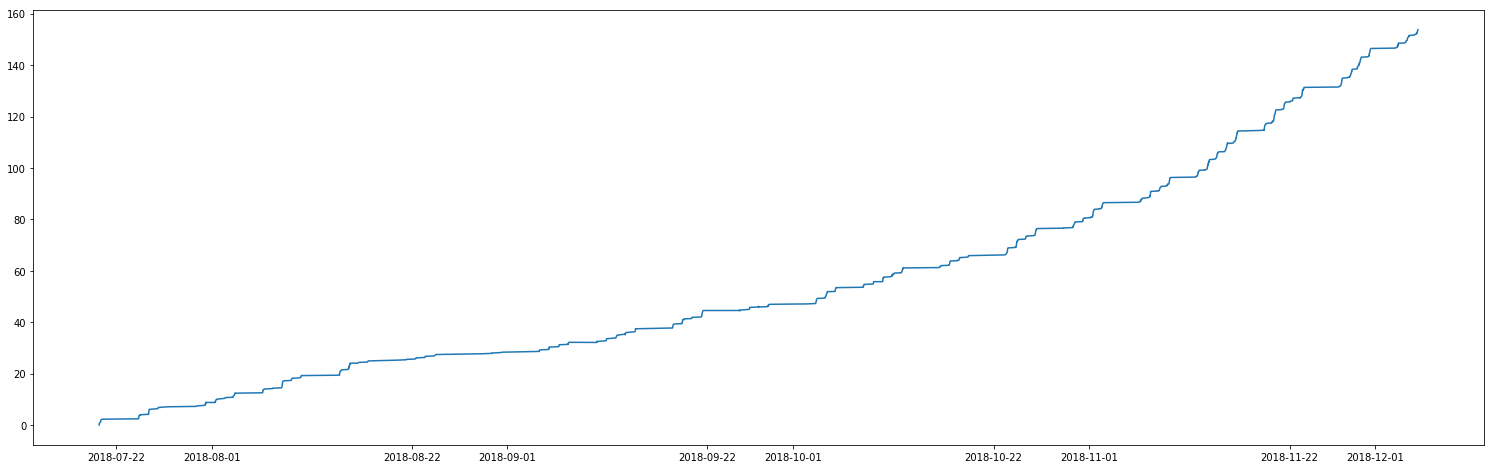

Buy Accuracy: 0.8630490956072352
Sell Accuracy: 0.8041733547351525
HL Sharpe: 14.602409


category     203
float32     5181
dtype: int64
category     203
float32     5181
dtype: int64
HL Results
Trade Pct Predicted HL: 0.32608695652173914
Trade Pct Actual Target HL 0.5434782608695652
Val Predictions P/L HL BEFORE FEES: 11810.000006109476
Val Predictions P/L HL AFTER FEES: 11285.000006109476
Val Class 4: 2699.9999999999995
Val Class 3: 1540.0000005960462
Val Class 1: 2300.000000745058
Val Class 0: 5270.000004768371


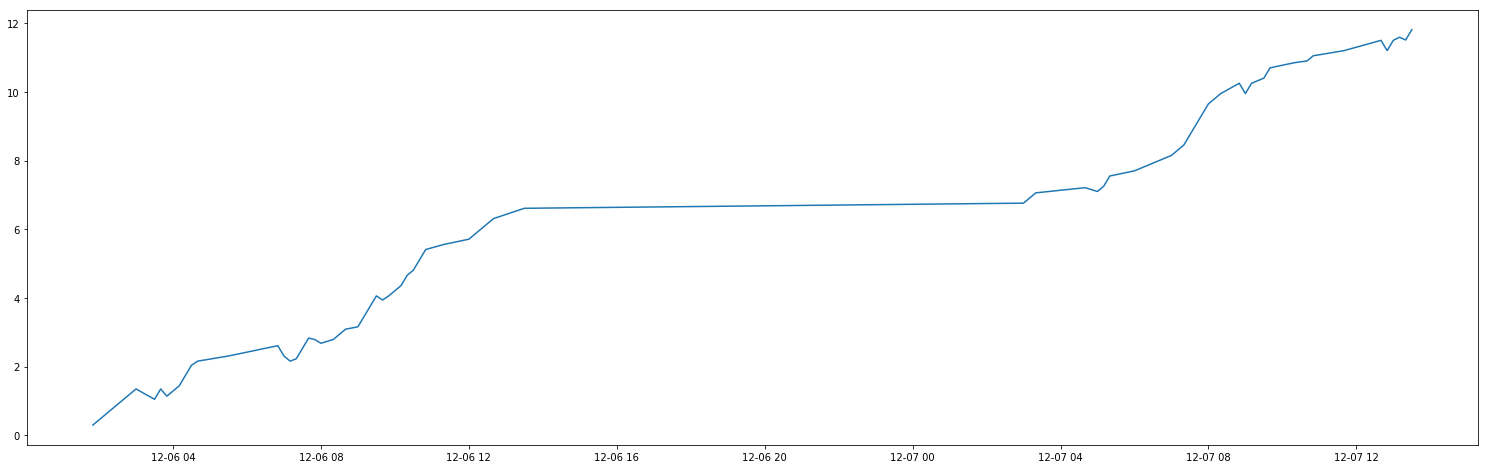

Buy Accuracy: 0.9047619047619048
Sell Accuracy: 0.7777777777777778
HL Sharpe: 3.342707


category     203
float32     5181
dtype: int64
category     203
float32     5181
dtype: int64
HL Results
Trade Pct Predicted HL: 0.02693965517241379
Trade Pct Actual Target HL 0.3329741379310345
Test Predictions P/L HL BEFORE FEES: 199.99999068677423
Test Predictions P/L HL AFTER FEES: -150.00000931322577
Test Class 4: 0.0
Test Class 3: 359.9999986588955
Test Class 1: 339.9999856948852
Test Class 0: -499.99999366700655


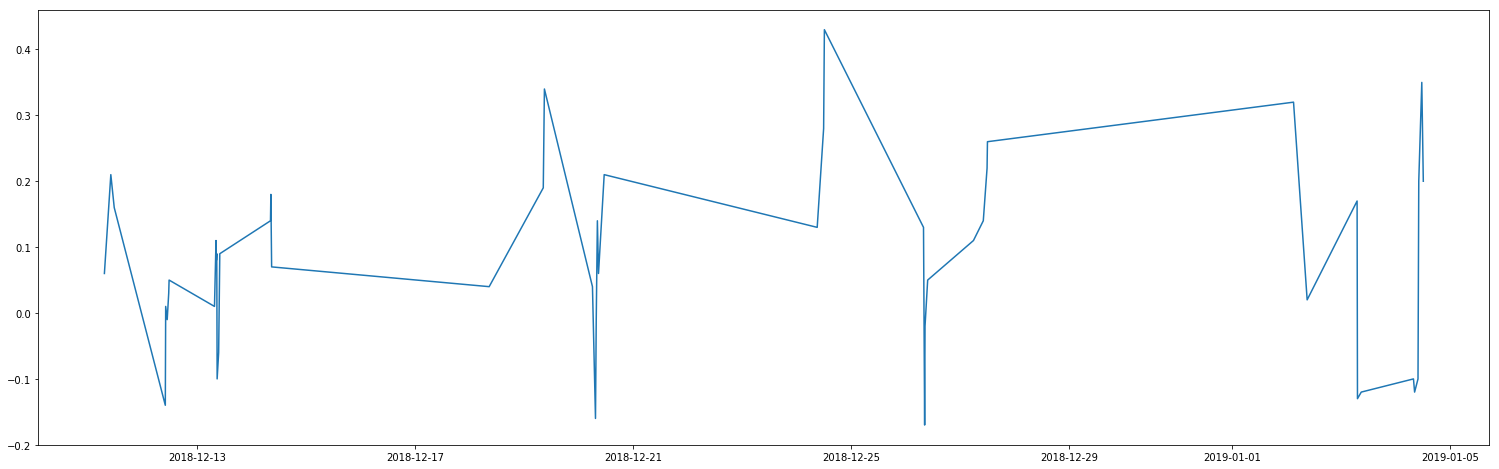

Buy Accuracy: 0.6666666666666666
Sell Accuracy: 0.574468085106383
HL Sharpe: 0.073922396


{'boosting_type':'gbdt', 'class_weight':None, 'colsample_bytree':1.0,
'importance_type':'split', 'learning_rate':0.01, 'max_depth':12,
'min_child_samples':32, 'min_child_weight':0.001, 'min_split_gain':0.0,
'n_estimators':128, 'device':'gpu', 'n_jobs':32, 'num_leaves':60, 'objective':'multi:logloss',
'random_state':0, 'reg_alpha':0.0, 'reg_lambda':0.6, 'silent':True,
'subsample':1.0, 'subsample_for_bin':200000, 'subsample_freq':0}
strong_buy_HL: 0.3
med_buy_HL: 0.15
no_trade_HL: 0.15
med_sell_HL: 0.15
strong_sell_HL: 0.3
strong_cap_HL: 0.3
med_cap_HL: 0.15
stop_HL: 0.3
PredProb_ON
min_prob0 0.38
min_prob1 0.38
min_prob3 0.2
min_prob4 0.2


In [9]:
# for setting all values to be either continuous or to have categorical variables
if config['PARAMS']['need_cont_vars'] == 'TRUE':
    need_cont_vars_param = True
elif config['PARAMS']['need_cont_vars'] == 'FALSE':
    need_cont_vars_param = False
if config['PARAMS']['plot_importances'] == 'TRUE':
    plot_importances_param = True
elif config['PARAMS']['plot_importances'] == 'FALSE':
    plot_importances_param = False



if config['PARAMS']['SMOTE_RATIO'] == 'FALSE':
    smote_ratio_param = None
elif config['PARAMS']['SMOTE_RATIO'] != 'FALSE':
    smote_ratio_param = ast.literal_eval(config['PARAMS']['SMOTE_RATIO'])

print(pd.concat([X_train, y_train_HL], axis=1))

####################################################
#                   MODEL TRAINING
####################################################

if config['PARAMS']['HL_ON'] == 'TRUE':

    if config['PARAMS']['RAW_ON'] == 'TRUE':
        # HL RAW
        if config['MODEL']['xgbc'] == 'TRUE':
            print('Running XGBClassifier RAW-HL')
            raw_model = XGBClassifier(**ast.literal_eval(config['PARAMS']['raw_model_hyperparams_HL']))

        if config['MODEL']['lgbmc'] == 'TRUE':
            print('Running LGBMClassifier RAW-HL')
            raw_model = LGBMClassifier(**ast.literal_eval(config['PARAMS']['raw_model_hyperparams_HL']))

        if config['MODEL']['gbmc'] == 'TRUE':
            print('Running GradientBoostingClassifier RAW-HL')
            raw_model = GradientBoostingClassifier(**ast.literal_eval(config['PARAMS']['raw_model_hyperparams_HL']))

        if config['MODEL']['lrc'] == 'TRUE':
            print('Running LogisticRegressionCV RAW-HL')
            raw_model = LogisticRegressionCV(**ast.literal_eval(config['PARAMS']['raw_model_hyperparams_HL']))

        if config['MODEL']['svc'] == 'TRUE':
            print('Running SVC RAW-HL')
            raw_model = SVC(**ast.literal_eval(config['PARAMS']['raw_model_hyperparams_HL']))

        if config['MODEL']['rfc'] == 'TRUE':
            print('Running RandomForestClassifier RAW-HL')
            raw_model = RandomForestClassifier(**ast.literal_eval(config['PARAMS']['raw_model_hyperparams_HL']))

        raw_model_HL = TrainModel(model=raw_model_HL,
                                  X_train_fit=X_train, y_train_fit=y_train_HL, X_val_fit=X_val, y_val_fit=y_val_HL,
                                  X_test_unseen=X_test, y_test_unseen=y_test_HL,
                                  need_cont_vars=need_cont_vars_param,
                                  plot_importances=plot_importances_param).train_traditional_ML_model()


        CalcResults(model=raw_model_HL, X=X_train, y=y_train_HL, predictions='Train Predictions',
                    stop=stop_HL, strong_cap=strong_cap_HL, med_cap=med_cap_HL,
                    multiplier=multiplier, need_cont_vars=need_cont_vars_param,
                    HL=False, NN=False).calc_results()

        CalcResults(model=raw_model_HL, X=X_val, y=y_val_HL, predictions='Val Predictions',
                    stop=stop_HL, strong_cap=strong_cap_HL, med_cap=med_cap_HL,
                    multiplier=multiplier, need_cont_vars=need_cont_vars_param,
                    HL=False, NN=False).calc_results()

        CalcResults(model=raw_model_HL, X=X_test, y=y_test_HL, predictions='Test Predictions',
                    stop=stop_HL, strong_cap=strong_cap_HL, med_cap=med_cap_HL,
                    multiplier=multiplier, need_cont_vars=need_cont_vars_param,
                    HL=False, NN=False).calc_results()


    # HL SMOTE
    if config['PARAMS']['SMOTE_ON'] == 'TRUE':

        print('Applying SMOTE...')
        X_train_smote, X_val_smote, y_train_smote_HL, y_val_smote_HL = create_smote_df(need_cont_vars=need_cont_vars_param, ratio=smote_ratio_param)
        print(X_train_smote.shape, X_val_smote.shape, y_train_smote_HL.shape, y_val_smote_HL.shape)

        if config['MODEL']['xgbc'] == 'TRUE':
            print('Running XGBClassifier SMOTE-HL')
            model_name = 'XGBC'
            smote_model = XGBClassifier(**ast.literal_eval(config['PARAMS']['smote_model_hyperparams_HL']))

        if config['MODEL']['lgbmc'] == 'TRUE':
            print('Running LGBMClassifier SMOTE-HL')
            model_name = 'LGBMC'
            smote_model = LGBMClassifier(**ast.literal_eval(config['PARAMS']['smote_model_hyperparams_HL']))

        if config['MODEL']['gbmc'] == 'TRUE':
            print('Running GradientBoostingClassifier SMOTE-HL')
            model_name = 'GBMC'
            smote_model = GradientBoostingClassifier(**ast.literal_eval(config['PARAMS']['smote_model_hyperparams_HL']))

        if config['MODEL']['lrc'] == 'TRUE':
            print('Running LogisticRegressionCV SMOTE-HL')
            model_name = 'LRC'
            smote_model = LogisticRegressionCV(**ast.literal_eval(config['PARAMS']['smote_model_hyperparams_HL']))

        if config['MODEL']['svc'] == 'TRUE':
            print('Running SVC SMOTE-HL')
            model_name = 'SVC'
            smote_model = SVC(**ast.literal_eval(config['PARAMS']['smote_model_hyperparams_HL']))

        if config['MODEL']['rfc'] == 'TRUE':
            print('Running RandomForestClassifier SMOTE-HL')
            model_name = 'RFC'
            smote_model = RandomForestClassifier(**ast.literal_eval(config['PARAMS']['smote_model_hyperparams_HL']))

        smote_model_HL = TrainModel(smote_model,
                                    X_train_smote, y_train_smote_HL, X_val_smote, y_val_smote_HL,
                                    X_test, y_test_HL,
                                    need_cont_vars=need_cont_vars_param,
                                    plot_importances=plot_importances_param).train_traditional_ML_model()


        CalcResults(smote_model_HL, X_train, y_train_HL, predictions='Train Predictions',
                    stop=stop_HL, strong_cap=strong_cap_HL, med_cap=med_cap_HL,
                    multiplier=multiplier, need_cont_vars=need_cont_vars_param,
                    HL=True, NN=False).calc_results()
        CalcResults(smote_model_HL, X_val, y_val_HL, predictions='Val Predictions',
                    stop=stop_HL, strong_cap=strong_cap_HL, med_cap=med_cap_HL,
                    multiplier=multiplier, need_cont_vars=need_cont_vars_param,
                    HL=True, NN=False).calc_results()
        CalcResults(smote_model_HL, X_test, y_test_HL, predictions='Test Predictions',
                    stop=stop_HL, strong_cap=strong_cap_HL, med_cap=med_cap_HL,
                    multiplier=multiplier, need_cont_vars=need_cont_vars_param,
                    HL=True, NN=False).calc_results()





if config['PARAMS']['ACTUAL_ON'] == 'TRUE':

    if config['PARAMS']['RAW_ON'] == 'TRUE':
        # Actual RAW

        if config['MODEL']['xgbc'] == 'TRUE':
            print('Running XGBClassifier RAW-ACTUAL')
            raw_model = XGBClassifier(**ast.literal_eval(config['PARAMS']['raw_model_hyperparams_ACTUAL']))

        if config['MODEL']['lgbmc'] == 'TRUE':
            print('Running LGBMClassifier RAW-ACTUAL')
            raw_model = LGBMClassifier(**ast.literal_eval(config['PARAMS']['raw_model_hyperparams_ACTUAL']))

        if config['MODEL']['gbmc'] == 'TRUE':
            print('Running GradientBoostingClassifier RAW-ACTUAL')
            raw_model = GradientBoostingClassifier(**ast.literal_eval(config['PARAMS']['raw_model_hyperparams_ACTUAL']))

        if config['MODEL']['lrc'] == 'TRUE':
            print('Running LogisticRegressionCV RAW-ACTUAL')
            raw_model = LogisticRegressionCV(**ast.literal_eval(config['PARAMS']['raw_model_hyperparams_ACTUAL']))

        if config['MODEL']['svc'] == 'TRUE':
            print('Running SVC RAW-ACTUAL')
            raw_model = SVC(**ast.literal_eval(config['PARAMS']['raw_model_hyperparams_ACTUAL']))

        if config['MODEL']['rfc'] == 'TRUE':
            print('Running RandomForestClassifier RAW-ACTUAL')
            raw_model = RandomForestClassifier(**ast.literal_eval(config['PARAMS']['raw_model_hyperparams_ACTUAL']))


        raw_model_actual = TrainModel(raw_model,
                                      X_train, y_train_actual, X_val, y_val_actual,
                                      X_test, y_test_actual,
                                      need_cont_vars=need_cont_vars_param,
                                      plot_importances=plot_importances_param).train_traditional_ML_model()


        CalcResults(model=raw_model_actual, X=X_train, y=y_train_actual, predictions='Train Predictions',
                    stop=stop_actual, strong_cap=strong_cap_actual, med_cap=med_cap_actual,
                    multiplier=multiplier, need_cont_vars=need_cont_vars_param,
                    HL=False, NN=False).calc_results()

        CalcResults(model=raw_model_actual, X=X_val, y=y_val_actual, predictions='Val Predictions',
                    stop=stop_actual, strong_cap=strong_cap_actual, med_cap=med_cap_actual,
                    multiplier=multiplier, need_cont_vars=need_cont_vars_param,
                    HL=False, NN=False).calc_results()

        CalcResults(model=raw_model_actual, X=X_test, y=y_test_actual, predictions='Test Predictions',
                    stop=stop_actual, strong_cap=strong_cap_actual, med_cap=med_cap_actual,
                    multiplier=multiplier, need_cont_vars=need_cont_vars_param,
                    HL=False, NN=False).calc_results()
    

    print(X_train[['CL_Prev10minMove']])
    # Actual SMOTE
    if config['PARAMS']['SMOTE_ON'] == 'TRUE':

        X_train_smote, X_val_smote, y_train_smote_actual, y_val_smote_actual = create_smote_df(need_cont_vars=need_cont_vars_param, ratio=smote_ratio_param)
        print(X_train_smote.shape, X_val_smote.shape, y_train_smote_actual.shape, y_val_smote_actual.shape)

        if config['MODEL']['xgbc'] == 'TRUE':
            print('Running XGBClassifier SMOTE-ACTUAL')
            model_name = 'XGBC'
            smote_model = XGBClassifier(**ast.literal_eval(config['PARAMS']['smote_model_hyperparams_ACTUAL']))

        if config['MODEL']['lgbmc'] == 'TRUE':
            print('Running LGBMClassifier SMOTE-ACTUAL')
            model_name = 'LGBMC'
            smote_model = LGBMClassifier(**ast.literal_eval(config['PARAMS']['smote_model_hyperparams_ACTUAL']))

        if config['MODEL']['gbmc'] == 'TRUE':
            print('Running GradientBoostingClassifier SMOTE-ACTUAL')
            model_name = 'GBMC'
            smote_model = GradientBoostingClassifier(**ast.literal_eval(config['PARAMS']['smote_model_hyperparams_ACTUAL']))

        if config['MODEL']['lrc'] == 'TRUE':
            print('Running LogisticRegressionCV SMOTE-ACTUAL')
            model_name = 'LRC'
            smote_model = LogisticRegressionCV(**ast.literal_eval(config['PARAMS']['smote_model_hyperparams_ACTUAL']))

        if config['MODEL']['svc'] == 'TRUE':
            print('Running SVC SMOTE-ACTUAL')
            model_name = 'SVC'
            smote_model = SVC(**ast.literal_eval(config['PARAMS']['smote_model_hyperparams_ACTUAL']))

        if config['MODEL']['rfc'] == 'TRUE':
            print('Running RandomForestClassifier SMOTE-ACTUAL')
            model_name = 'RFC'
            smote_model = RandomForestClassifier(**ast.literal_eval(config['PARAMS']['smote_model_hyperparams_ACTUAL']))

        smote_model_actual = TrainModel(smote_model,
                                        X_train_smote, y_train_smote_actual, X_val_smote, y_val_smote_actual,
                                        X_test, y_test_actual,
                                        need_cont_vars=need_cont_vars_param,
                                        plot_importances=plot_importances_param).train_traditional_ML_model()

        CalcResults(smote_model_actual, X_train, y_train_actual, predictions='Train Predictions',
                    stop=stop_actual, strong_cap=strong_cap_actual, med_cap=med_cap_actual,
                    multiplier=multiplier, need_cont_vars=need_cont_vars_param,
                    HL=False, NN=False).calc_results()
        CalcResults(smote_model_actual, X_val, y_val_actual, predictions='Val Predictions',
                    stop=stop_actual, strong_cap=strong_cap_actual, med_cap=med_cap_actual,
                    multiplier=multiplier, need_cont_vars=need_cont_vars_param,
                    HL=False, NN=False).calc_results()
        CalcResults(smote_model_actual, X_test, y_test_actual, predictions='Test Predictions',
                    stop=stop_actual, strong_cap=strong_cap_actual, med_cap=med_cap_actual,
                    multiplier=multiplier, need_cont_vars=need_cont_vars_param,
                    HL=False, NN=False).calc_results()

if config['PARAMS']['HL_ON'] == 'TRUE':
    if config['PARAMS']['RAW_ON'] == 'TRUE':
        print(config['PARAMS']['raw_model_hyperparams_HL'])
    if config['PARAMS']['SMOTE_ON'] == 'TRUE':
        print(config['PARAMS']['smote_model_hyperparams_HL'])
        print('strong_buy_HL:', strong_buy_HL)
        print('med_buy_HL:', med_buy_HL)
        print('no_trade_HL:', no_trade_HL)
        print('med_sell_HL:', med_sell_HL)
        print('strong_sell_HL:', strong_sell_HL)
        print('strong_cap_HL:', strong_cap_HL)
        print('med_cap_HL:', med_cap_HL)
        print('stop_HL:', stop_HL)
        if config['PARAMS']['PredProb_ON'] == 'TRUE':
            print('PredProb_ON')
            print('min_prob0', min_prob0)
            print('min_prob1', min_prob1)
            print('min_prob3', min_prob3)
            print('min_prob4', min_prob4)

if config['PARAMS']['ACTUAL_ON'] == 'TRUE':
    if config['PARAMS']['RAW_ON'] == 'TRUE':
        print(config['PARAMS']['raw_model_hyperparams_ACTUAL'])
    if config['PARAMS']['SMOTE_ON'] == 'TRUE':
        print(config['PARAMS']['smote_model_hyperparams_ACTUAL'])


# SAVE RAW
if config['MODEL']['save_raw'] == 'TRUE':
    if config['PARAMS']['HL_ON'] == 'TRUE':
        pickle.dump(raw_model_HL, open(config['PATH']['model_outpath'] + config['NAME']['product'] + model_name + '_RAW-HL_' + str(datetime.datetime.today().date()) + '.pickle.dat', 'wb'))
        # np.savetxt(config['PATH']['model_outpath'] + config['NAME']['product'] + model_name + '_RAW-HL_COLUMNS.txt', np.array(X_train.columns), fmt='%s', delimiter=',')
        X_train.to_csv(config['PATH']['model_outpath'] + config['NAME']['product'] + model_name + '_RAW-HL_X_train_' + str(datetime.datetime.today().date()) + '.csv')

    if config['PARAMS']['ACTUAL_ON'] == 'TRUE':
        pickle.dump(raw_model_actual, open(config['PATH']['model_outpath'] + config['NAME']['product'] + model_name + '_RAW-ACTUAL_' + str(datetime.datetime.today().date()) + '.pickle.dat', 'wb'))
        # np.savetxt(config['PATH']['model_outpath'] + config['NAME']['product'] + model_name + '_RAW-ACTUAL_COLUMNS.txt', np.array(X_train.columns), fmt='%s', delimiter=',')
        X_train.to_csv(config['PATH']['model_outpath'] + config['NAME']['product'] + model_name + '_RAW-ACTUAL_X_train_' + str(datetime.datetime.today().date()) + '.csv')

# SAVE SMOTE
if config['MODEL']['save_smote'] == 'TRUE':
    if config['PARAMS']['HL_ON'] == 'TRUE':
        pickle.dump(smote_model_HL, open(config['PATH']['model_outpath'] + config['NAME']['product'] + model_name + '_SMOTE-HL_' + str(datetime.datetime.today().date()) + '.pickle.dat', 'wb'))
        # np.savetxt(config['PATH']['model_outpath'] + config['NAME']['product'] + model_name + '_SMOTE-HL_COLUMNS.txt', np.array(X_train.columns), fmt='%s', delimiter=',')
        X_train.to_csv(config['PATH']['model_outpath'] + config['NAME']['product'] + model_name + '_SMOTE-HL_X_train_' + str(datetime.datetime.today().date()) + '.csv')

    if config['PARAMS']['ACTUAL_ON'] == 'TRUE':
        pickle.dump(smote_model_actual, open(config['PATH']['model_outpath'] + config['NAME']['product'] + model_name + '_SMOTE-ACTUAL_' + str(datetime.datetime.today().date()) + '.pickle.dat', 'wb'))
        # np.savetxt(config['PATH']['model_outpath'] + config['NAME']['product'] + model_name + '_SMOTE-ACTUAL_COLUMNS.txt', np.array(X_train.columns), fmt='%s', delimiter=',')
        X_train.to_csv(config['PATH']['model_outpath'] + config['NAME']['product'] + model_name + '_SMOTE-ACTUAL_X_train_' + str(datetime.datetime.today().date()) + '.csv')


### Train more models and examine performance using different parameters and hyperparameters - HL

Train Accuracy: 0.8672709923664123
Val Accuracy: 0.13543599257884972
Test Accuracy: 0.5883620689655172
Train F1: 0.8780084315406709
Val F1: 0.07136272534433495
Test F1: 0.6134103725752299
Train:                    pre       rec       spe        f1       geo       iba       sup

        0.0       0.98      0.88      0.99      0.93      0.94      0.87      9943
        1.0       0.89      0.82      0.95      0.85      0.88      0.77      9794
        2.0       0.94      0.88      0.98      0.91      0.93      0.85      9626
        3.0       0.46      0.98      0.92      0.62      0.95      0.91      1988
        4.0       0.38      1.00      1.00      0.55      1.00      1.00        89

avg / total       0.90      0.87      0.97      0.88      0.92      0.83     31440

Val:                    pre       rec       spe        f1       geo       iba       sup

        0.0       0.00      0.00      1.00      0.00      0.00      0.00      5206
        1.0       0.00      0.00      1.00      0

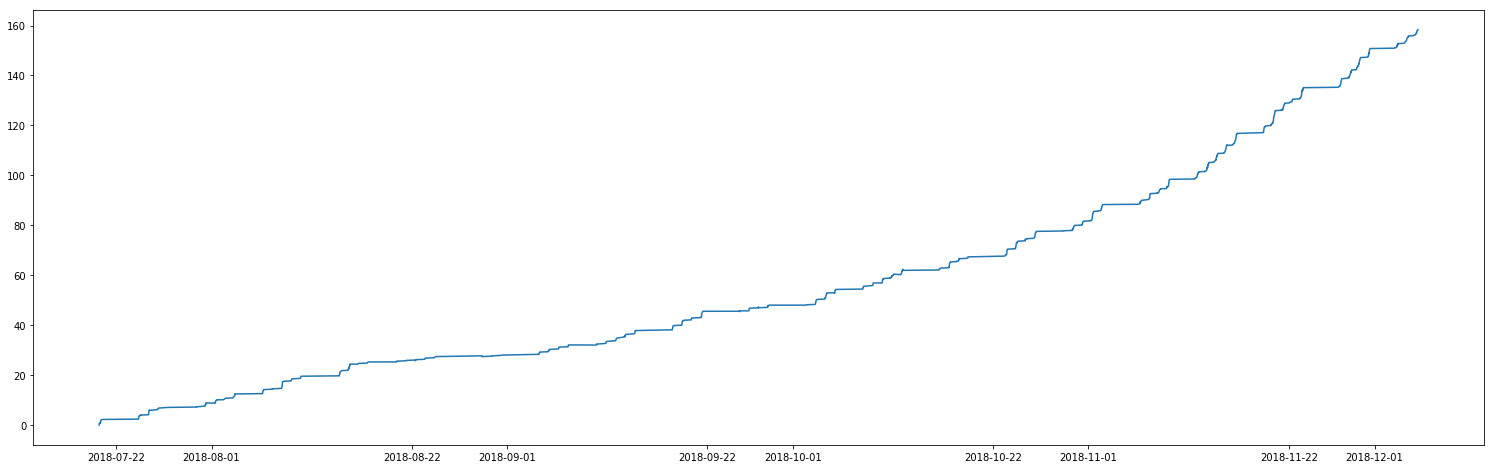

Buy Accuracy: 0.8611825192802056
Sell Accuracy: 0.7726638772663877
HL Sharpe: 13.832473


category     203
float32     5181
dtype: int64
category     203
float32     5181
dtype: int64
HL Results
Trade Pct Predicted HL: 0.3391304347826087
Trade Pct Actual Target HL 0.5434782608695652
Val Predictions P/L HL BEFORE FEES: 11790.000004321335
Val Predictions P/L HL AFTER FEES: 11244.000004321335
Val Class 4: 2699.9999999999995
Val Class 3: 1540.0000005960462
Val Class 1: 2450.000000745058
Val Class 0: 5100.000002980231


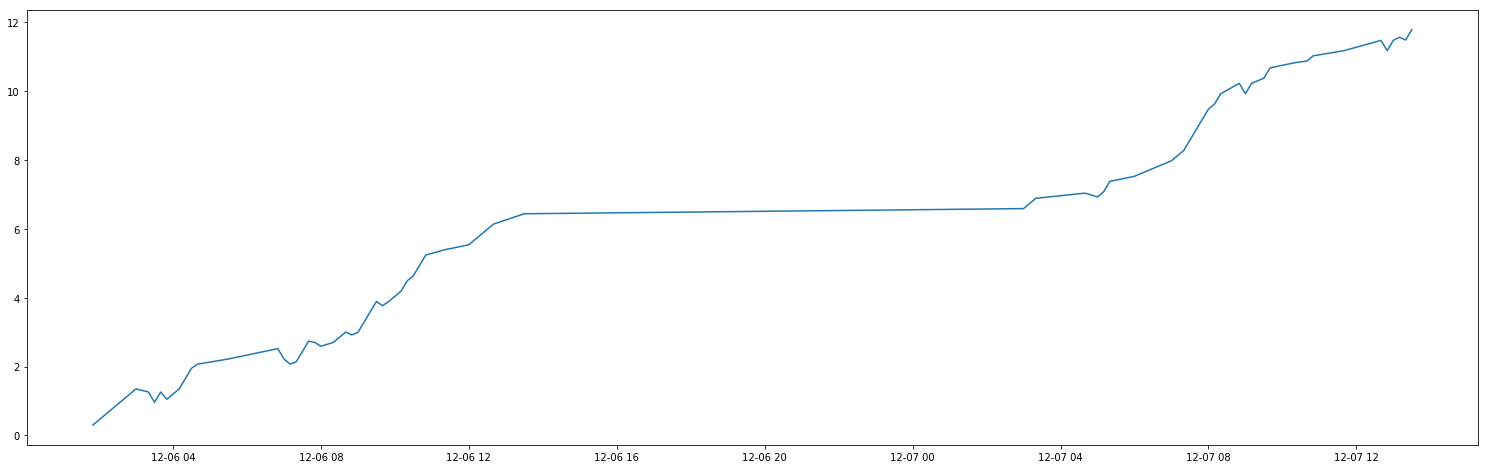

Buy Accuracy: 0.9047619047619048
Sell Accuracy: 0.7543859649122807
HL Sharpe: 3.2602804


category     203
float32     5181
dtype: int64
category     203
float32     5181
dtype: int64
HL Results
Trade Pct Predicted HL: 0.08728448275862069
Trade Pct Actual Target HL 0.3329741379310345
Test Predictions P/L HL BEFORE FEES: -2190.0000233203177
Test Predictions P/L HL AFTER FEES: -3324.0000233203177
Test Class 4: 0.0
Test Class 3: 289.99999836087227
Test Class 1: -2520.0000163167715
Test Class 0: 39.999994635581906


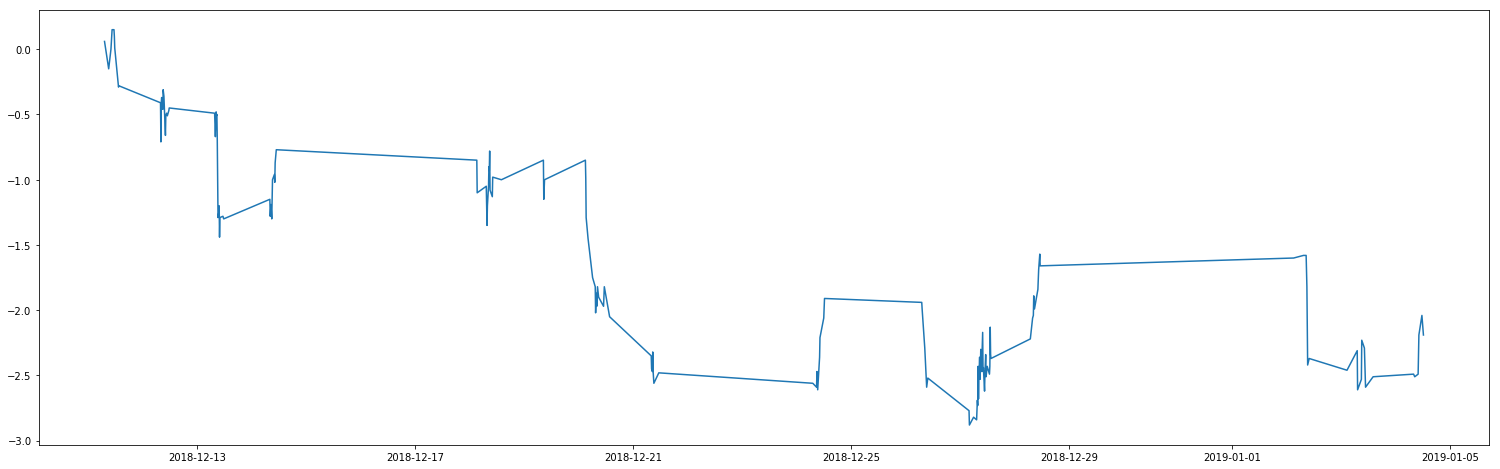

Buy Accuracy: 0.5
Sell Accuracy: 0.46835443037974683
HL Sharpe: -0.4321709




Target_HL  Test Predictions  \
Datetime                                                 
2018-12-11 07:10:00-06:00        2.0               1.0   
2018-12-11 09:00:00-06:00        3.0               1.0   
2018-12-11 10:00:00-06:00        1.0               1.0   
2018-12-11 10:30:00-06:00        0.0               1.0   
2018-12-11 11:20:00-06:00        2.0               1.0   
2018-12-11 11:30:00-06:00        2.0               1.0   
2018-12-11 11:40:00-06:00        2.0               1.0   
2018-12-11 13:20:00-06:00        4.0               1.0   
2018-12-11 13:30:00-06:00        2.0               0.0   
2018-12-12 07:50:00-06:00        3.0               1.0   
2018-12-12 08:00:00-06:00        4.0               0.0   
2018-12-12 08:10:00-06:00        0.0               0.0   
2018-12-12 08:20:00-06:00        2.0               0.0   
2018-12-12 08:40:00-06:00        3.0               0.0   
2018-12-12 08:50:00-06:00        2.0               0.0   
2018-12-12 09:00:00-06:00        0.0               1.0   
2018-12-12 09:20:00-06:00        3.0               1.0   
2018-12-12 10:00:00-06:00        4.0               1.0   
2018-12-12 10:10:00-06:00        1.0               1.0   
2018-12-12 10:30:00-06:00        2.0               1.0   
2018-12-12 10:50:00-06:00        2.0               1.0   
2018-12-12 11:30:00-06:00        2.0               1.0   
2018-12-12 11:40:00-06:00        2.0               1.0   
2018-12-13 07:40:00-06:00        2.0               0.0   
2018-12-13 07:50:00-06:00        2.0               0.0   
2018-12-13 08:00:00-06:00        2.0               1.0   
2018-12-13 08:10:00-06:00        1.0               0.0   
2018-12-13 08:20:00-06:00        2.0               0.0   
2018-12-13 08:30:00-06:00        2.0               0.0   
2018-12-13 08:40:00-06:00        2.0               0.0   
...                              ...               ...   
2018-12-28 08:30:00-06:00        1.0               1.0   
2018-12-28 08:50:00-06:00        2.0               1.0   
2018-12-28 10:20:00-06:00        1.0               1.0   
2018-12-28 10:40:00-06:00        1.0               1.0   
2018-12-28 11:10:00-06:00        1.0               0.0   
2018-12-28 11:20:00-06:00        2.0               1.0   
2019-01-02 03:00:00-06:00        2.0               3.0   
2019-01-02 07:10:00-06:00        2.0               0.0   
2019-01-02 07:20:00-06:00        2.0               0.0   
2019-01-02 08:30:00-06:00        2.0               1.0   
2019-01-02 08:50:00-06:00        3.0               1.0   
2019-01-02 09:00:00-06:00        4.0               0.0   
2019-01-02 09:10:00-06:00        4.0               1.0   
2019-01-02 09:50:00-06:00        2.0               1.0   
2019-01-03 02:30:00-06:00        2.0               1.0   
2019-01-03 07:00:00-06:00        3.0               1.0   
2019-01-03 07:10:00-06:00        4.0               1.0   
2019-01-03 08:40:00-06:00        3.0               1.0   
2019-01-03 08:50:00-06:00        2.0               1.0   
2019-01-03 09:00:00-06:00        0.0               0.0   
2019-01-03 10:10:00-06:00        3.0               1.0   
2019-01-03 10:40:00-06:00        4.0               1.0   
2019-01-03 14:00:00-06:00        2.0               1.0   
2019-01-04 07:50:00-06:00        3.0               1.0   
2019-01-04 08:20:00-06:00        3.0               1.0   
2019-01-04 09:50:00-06:00        2.0               1.0   
2019-01-04 10:00:00-06:00        0.0               1.0   
2019-01-04 10:10:00-06:00        0.0               1.0   
2019-01-04 11:30:00-06:00        3.0               3.0   
2019-01-04 12:10:00-06:00        3.0               1.0   

                           CL_Actual10minHighMove  CL_Actual10minLowMove  \
Datetime                                                                   
2018-12-11 07:10:00-06:00                    0.03                  -0.10   
2018-12-11 09:00:00-06:00                    0.29                  -0.03   
2018-12-11 10:00:00-06:00                    0.06                  -

In [25]:
min_prob0 = 0.32
min_prob1 = 0.32
min_prob3 = 0.2
min_prob4 = 0.2

smote_model_hyperparams_HL = {'boosting_type':'gbdt', 'class_weight':None, 'colsample_bytree':1.0,
                              'importance_type':'split', 'learning_rate':0.1, 'max_depth':6,
                              'min_child_samples':32, 'min_child_weight':0.001, 'min_split_gain':0.0,
                              'n_estimators':100, 'device':'gpu', 'n_jobs':32, 'num_leaves':31, 'objective':'multi:logloss',
                              'random_state':0, 'reg_alpha':0.0, 'reg_lambda':5.0, 'silent':True,
                              'subsample':.8, 'subsample_for_bin':200000, 'subsample_freq':0}

smote_model_HL = TrainModel(smote_model,
                            X_train_smote, y_train_smote_HL, X_val_smote, y_val_smote_HL,
                            X_test, y_test_HL,
                            need_cont_vars=need_cont_vars_param,
                            plot_importances=plot_importances_param).train_traditional_ML_model()


CalcResults(smote_model_HL, X_train, y_train_HL, predictions='Train Predictions',
            stop=stop_HL, strong_cap=strong_cap_HL, med_cap=med_cap_HL,
            multiplier=multiplier, need_cont_vars=need_cont_vars_param,
            HL=True, NN=False).calc_results()
CalcResults(smote_model_HL, X_val, y_val_HL, predictions='Val Predictions',
            stop=stop_HL, strong_cap=strong_cap_HL, med_cap=med_cap_HL,
            multiplier=multiplier, need_cont_vars=need_cont_vars_param,
            HL=True, NN=False).calc_results()
CalcResults(smote_model_HL, X_test, y_test_HL, predictions='Test Predictions',
            stop=stop_HL, strong_cap=strong_cap_HL, med_cap=med_cap_HL,
            multiplier=multiplier, need_cont_vars=need_cont_vars_param,
            HL=True, NN=False).calc_results()

In [23]:
import pickle

pickle.load(open('/home/melgazar9/Trading/TD/Live-Trading/CL/models/CL_10min_models/GoodModels/CL_10min_LGBMC_SMOTE-HL_2018-12-29.pickle.dat', 'rb'))

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        device='gpu', importance_type='split', learning_rate=0.1,
        max_depth=6, min_child_samples=20, min_child_weight=0.001,
        min_split_gain=0.0, n_estimators=100, n_jobs=32, num_leaves=31,
        objective=None, random_state=0, reg_alpha=0.0, reg_lambda=0.0,
        silent=True, subsample=0.6, subsample_for_bin=200000,
        subsample_freq=0)

In [29]:
(.13 - .02)/2

0.055

In [30]:
df['CL_Prev10minMove'].pct_change()

Datetime
2018-07-19 19:00:00-05:00          NaN
2018-07-19 19:10:00-05:00     5.500000
2018-07-19 19:20:00-05:00    -0.538462
2018-07-19 19:30:00-05:00    -2.000000
2018-07-19 19:40:00-05:00    -1.500000
2018-07-19 19:50:00-05:00    -1.666667
2018-07-19 20:00:00-05:00    -1.500000
2018-07-19 20:10:00-05:00    10.000000
2018-07-19 20:20:00-05:00    -2.090909
2018-07-19 20:30:00-05:00    -0.583333
2018-07-19 20:40:00-05:00     3.800000
2018-07-19 20:50:00-05:00    -0.958333
2018-07-19 21:00:00-05:00    -4.000000
2018-07-19 21:10:00-05:00     2.666667
2018-07-19 21:20:00-05:00    -1.181818
2018-07-19 21:30:00-05:00    -3.000000
2018-07-19 21:40:00-05:00     0.750000
2018-07-19 21:50:00-05:00    -1.571429
2018-07-19 22:00:00-05:00    -1.750000
2018-07-19 22:10:00-05:00    -3.666667
2018-07-19 22:20:00-05:00    -1.625000
2018-07-19 22:30:00-05:00    -1.600000
2018-07-19 22:40:00-05:00    -0.666667
2018-07-19 22:50:00-05:00     1.000000
2018-07-19 23:00:00-05:00    -3.000000
2018-07-19 23:10

In [19]:
pd.concat([X_train[['CL_Prev10minMove', 'CL_Prev10minLowMove', 'CL_Prev10minHighMove']].shift(-1), y_train_HL], axis=1)

CL_Prev10minMove  CL_Prev10minLowMove  \
Datetime                                                           
2018-07-19 19:00:00-05:00              0.13                -0.01   
2018-07-19 19:10:00-05:00              0.06                -0.03   
2018-07-19 19:20:00-05:00             -0.06                -0.07   
2018-07-19 19:30:00-05:00              0.03                -0.02   
2018-07-19 19:40:00-05:00             -0.02                -0.04   
2018-07-19 19:50:00-05:00              0.01                -0.06   
2018-07-19 20:00:00-05:00              0.11                -0.01   
2018-07-19 20:10:00-05:00             -0.12                -0.13   
2018-07-19 20:20:00-05:00             -0.05                -0.11   
2018-07-19 20:30:00-05:00             -0.24                -0.25   
2018-07-19 20:40:00-05:00             -0.01                -0.10   
2018-07-19 20:50:00-05:00              0.03                -0.02   
2018-07-19 21:00:00-05:00              0.11                -0.04   
2018-07-19 21:10:00-05:00             -0.02                -0.03   
2018-07-19 21:20:00-05:00              0.04                -0.01   
2018-07-19 21:30:00-05:00              0.07                 0.00   
2018-07-19 21:40:00-05:00             -0.04                -0.05   
2018-07-19 21:50:00-05:00              0.03                -0.01   
2018-07-19 22:00:00-05:00             -0.08                -0.09   
2018-07-19 22:10:00-05:00              0.05                -0.01   
2018-07-19 22:20:00-05:00             -0.03                -0.04   
2018-07-19 22:30:00-05:00             -0.01                -0.02   
2018-07-19 22:40:00-05:00             -0.02                -0.02   
2018-07-19 22:50:00-05:00              0.04                -0.01   
2018-07-19 23:00:00-05:00              0.04                -0.03   
2018-07-19 23:10:00-05:00              0.07                 0.00   
2018-07-19 23:20:00-05:00             -0.03                -0.04   
2018-07-19 23:30:00-05:00             -0.01                -0.04   
2018-07-19 23:40:00-05:00             -0.01                -0.02   
2018-07-19 23:50:00-05:00              0.06                -0.01   
...                                     ...                  ...   
2018-12-05 19:00:00-06:00             -0.08                -0.16   
2018-12-05 19:10:00-06:00              0.02                -0.05   
2018-12-05 19:20:00-06:00              0.09                -0.03   
2018-12-05 19:30:00-06:00             -0.04                -0.04   
2018-12-05 19:40:00-06:00              0.07                -0.02   
2018-12-05 19:50:00-06:00             -0.05                -0.07   
2018-12-05 20:00:00-06:00             -0.03                -0.07   
2018-12-05 20:10:00-06:00              0.02                -0.03   
2018-12-05 20:20:00-06:00              0.02                -0.01   
2018-12-05 20:30:00-06:00             -0.03                -0.08   
2018-12-05 20:40:00-06:00             -0.07                -0.09   
2018-12-05 20:50:00-06:00              0.00                -0.01   
2018-12-05 21:00:00-06:00              0.04                -0.02   
2018-12-05 21:10:00-06:00              0.00                -0.06   
2018-12-05 21:20:00-06:00             -0.02                -0.03   
2018-12-05 21:30:00-06:00              0.05                -0.03   
2018-12-05 21:40:00-06:00             -0.47                -0.56   
2018-12-05 21:50:00-06:00              0.18                -0.02   
2018-12-05 22:00:00-06:00              0.01                -0.04   
2018-12-05 22:10:00-06:00              0.04                -0.01   
2018-12-05 22:20:00-06:00             -0.01                -0.05   
2018-12-05 22:30:00-06:00             -0.02                -0.03   
2018-12-05 22:40:00-06:00              0.01                -0.02   
2018-12-05 22:50:00-06:00              0.10                -0.02   
2018-12-05 23:00:00-06:00             -0.11                -0.17   
2018-12-05 23:10:00-06:00              0.01                 0.00   
2018-12-05 23:2

In [31]:
df.head()

CL_Prev10minMove  CL_Prev10minRange  \
Datetime                                                         
2018-07-19 19:00:00-05:00              0.02               0.04   
2018-07-19 19:10:00-05:00              0.13               0.19   
2018-07-19 19:20:00-05:00              0.06               0.11   
2018-07-19 19:30:00-05:00             -0.06               0.07   
2018-07-19 19:40:00-05:00              0.03               0.06   

                           CL_Prev10minHighMove  CL_Prev10minLowMove  \
Datetime                                                               
2018-07-19 19:00:00-05:00                  0.02                -0.02   
2018-07-19 19:10:00-05:00                  0.18                -0.01   
2018-07-19 19:20:00-05:00                  0.08                -0.03   
2018-07-19 19:30:00-05:00                  0.00                -0.07   
2018-07-19 19:40:00-05:00                  0.04                -0.02   

                           CL_Prev10minVolume  ES_Prev10minMove  \
Datetime                                                          
2018-07-19 19:00:00-05:00               188.0              0.00   
2018-07-19 19:10:00-05:00              1950.0              1.75   
2018-07-19 19:20:00-05:00              1085.0              0.00   
2018-07-19 19:30:00-05:00               431.0              0.75   
2018-07-19 19:40:00-05:00               769.0              0.50   

                           ES_Prev10minRange  ES_Prev10minHighMove  \
Datetime                                                             
2018-07-19 19:00:00-05:00               1.00                  0.25   
2018-07-19 19:10:00-05:00               2.25                  2.00   
2018-07-19 19:20:00-05:00               1.00                  0.25   
2018-07-19 19:30:00-05:00               1.50                  1.25   
2018-07-19 19:40:00-05:00               1.75                  1.00   

                           ES_Prev10minLowMove  ES_Prev10minVolume    ...      \
Datetime                                                              ...       
2018-07-19 19:00:00-05:00                -0.75               525.0    ...       
2018-07-19 19:10:00-05:00                -0.25              1114.0    ...       
2018-07-19 19:20:00-05:00                -0.75               738.0    ...       
2018-07-19 19:30:00-05:00                -0.25              1168.0    ...       
2018-07-19 19:40:00-05:00                -0.75              1405.0    ...       

                           Hour_16  Hour_17  Hour_18  Hour_19  Hour_20  \
Datetime                                                                 
2018-07-19 19:00:00-05:00        0        0        0        0        0   
2018-07-19 19:10:00-05:00        0        0        0        0        0   
2018-07-19 19:20:00-05:00        0        0        0        0        0   
2018-07-19 19:30:00-05:00        0        0        0        0        0   
2018-07-19 19:40:00-05:00        0        0        0        0        0   

                           Hour_21  Hour_22  Hour_23  Quarter_3  Quarter_4  
Datetime                                                                    
2018-07-19 19:00:00-05:00        0        0        0          1          0  
2018-07-19 19:10:00-05:00        0        0        0          1          0  
2018-07-19 19:20:00-05:00        0        0        0          1          0  
2018-07-19 19:30:00-05:00        0        0        0          1          0  
2018-07-19 19:40:00-05:00        0        0        0          1          0  

[5 rows x 5389 columns]

In [ ]:
import pandas as pd
import numpy as np
import datetime
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
import configparser
import warnings
import feather
import time
from multiprocessing import Pool, Process
import ast

start_time = time.time()


config = configparser.ConfigParser()
config.read('/home/melgazar9/Trading/TD/Scripts/Trading-Scripts/Multi-Product/scripts/Multi-Product_10min_CreateFeatures.ini')

min_lookback = int(config['PARAMS']['min_lookback'])
max_lookback = int(config['PARAMS']['max_lookback']) + 1
lookback_increment = int(config['PARAMS']['lookback_increment'])

contracts = ast.literal_eval(config['PARAMS']['contracts'])


def get_df_init(df, timeframe, contracts):

    df_resampled = pd.DataFrame()

    for i in range(len(contracts)):

        df_ohlc = df.resample(timeframe).ohlc()
        df_volume = df[contracts[i] + '_Prev' + '5minVolume'].resample(timeframe).sum()


        df_resampled[contracts[i] + '_Prev' + timeframe + 'Open'] = df_ohlc[contracts[i] + '_Prev' + '5minOpen']['open']
        df_resampled[contracts[i] + '_Prev' + timeframe + 'High'] = df_ohlc[contracts[i] + '_Prev' + '5minHigh']['high']
        df_resampled[contracts[i] + '_Prev' + timeframe + 'Low'] = df_ohlc[contracts[i] + '_Prev' + '5minLow']['low']
        df_resampled[contracts[i] + '_Prev' + timeframe + 'Close'] = df_ohlc[contracts[i] + '_Prev' + '5minClose']['close']
        df_resampled[contracts[i] + '_Prev' + timeframe + 'Move'] = df_ohlc[contracts[i] + '_Prev' + '5minClose']['close'] - df_ohlc[contracts[i] + '_Prev' + '5minOpen']['open']
        df_resampled[contracts[i] + '_Prev' + timeframe + 'Range'] = df_ohlc[contracts[i] + '_Prev' + '5minHigh']['high'] - df_ohlc[contracts[i] + '_Prev' + '5minLow']['low']
        df_resampled[contracts[i] + '_Prev' + timeframe + 'HighMove'] = df_ohlc[contracts[i] + '_Prev' + '5minHigh']['high'] - df_ohlc[contracts[i] + '_Prev' + '5minOpen']['open']
        df_resampled[contracts[i] + '_Prev' + timeframe + 'LowMove'] = df_ohlc[contracts[i] + '_Prev' + '5minLow']['low'] - df_ohlc[contracts[i] + '_Prev' + '5minOpen']['open']
        df_resampled[contracts[i] + '_Prev' + timeframe + 'Volume'] = df_volume

    return df_resampled


def get_rolling_features(df, col, window, min_periods):

    df[col + 'Rolling' + str('Sum').strip('()') + '_Window' + str(window)] = df[col].rolling(window=window, min_periods=min_periods).sum()
    df[col + 'Rolling' + str('Mean').strip('()') + '_Window' + str(window)] = df[col].rolling(window=window, min_periods=min_periods).mean()
    df[col + 'Rolling' + str('Std').strip('()') + '_Window' + str(window)] = df[col].rolling(window=window, min_periods=min_periods).std()
    df[col + 'Rolling' + str('Max').strip('()') + '_Window' + str(window)] = df[col].rolling(window=window, min_periods=min_periods).max()
    df[col + 'Rolling' + str('Min').strip('()') + '_Window' + str(window)] = df[col].rolling(window=window, min_periods=min_periods).min()

    return df

def macd(df, features, nslow, nfast):

    for feature in features:
        df[feature+'MACD_'+str(nslow)+'-'+str(nfast)] = df[feature].ewm(span=nslow, adjust=True).mean() - df[feature].ewm(span=nfast, adjust=True).mean() # 26 -12 period
        df[feature+'9dMA_'+str(nslow)+'-'+str(nfast)] = df[feature+'MACD_'+str(nslow)+'-'+str(nfast)].rolling(window=9).mean()
    return df


def RSI(series, period):

    delta = series.diff().dropna()
    u = delta * 0
    d = u.copy()
    u[delta > 0] = delta[delta > 0]
    d[delta < 0] = -delta[delta < 0]
    u[u.index[period-1]] = np.mean( u[:period] ) # first value is sum of avg gains
    u = u.drop(u.index[:(period-1)])
    d[d.index[period-1]] = np.mean( d[:period] ) # first value is sum of avg losses
    d = d.drop(d.index[:(period-1)])
    rs = u.ewm(com=period-1, adjust=False).mean() / d.ewm(com=period-1, adjust=False).mean()
    rsi = pd.DataFrame(100 - 100 / (1 + rs)).rename(columns={series.name : str(series.name).strip('Close')+'RSI'})

    #df = pd.merge_asof(df, rsi, )
    return rsi


def ATR(df, feature):
    df[feature[0:-5]+'ATR'] = df[feature].ewm(span=10).mean()
    df[feature[0:-5]+'ATR'] = (df[feature[0:-5]+'ATR'].shift(1)*13 + df[feature]) /  14

    return df

def Bollinger_Bands(df, feature, window_size, num_of_std):

    rolling_mean = df[feature].rolling(window=window_size).mean()
    rolling_std  = df[feature].rolling(window=window_size).std()
    upper_band = rolling_mean + (rolling_std*num_of_std)
    lower_band = rolling_mean - (rolling_std*num_of_std)

    upper_band = pd.DataFrame(upper_band, index=upper_band.index).rename(columns={feature : feature+'UpperBB'})
    lower_band = pd.DataFrame(lower_band, index=lower_band.index).rename(columns={feature : feature+'LowerBB'})


    temp = pd.merge_asof(df, upper_band, left_index=True, right_index=True)
    temp = pd.merge_asof(temp, lower_band, left_index=True, right_index=True)

#     temp =  Bollinger_Bands(df, 'Prev10minClose', 20, 2)
    price_upperBB_diff = df[feature] - temp[feature+'UpperBB']
    price_lowerBB_diff = df[feature] - temp[feature+'LowerBB']
    temp[feature.strip('Close')+'Price-UpperBB_diff'] = price_upperBB_diff
    temp[feature.strip('Close')+'Price-LowerBB_diff'] = price_lowerBB_diff

    temp[feature.strip('Close')+'UpperBB_Change'] = temp[feature+'UpperBB'].diff()#.rename(columns={feature+'UpperBB':feature+'UpperBB_Change'})
    temp[feature.strip('Close')+'LowerBB_Change'] = temp[feature+'LowerBB'].diff()


    temp.drop([feature+'UpperBB'], axis=1, inplace=True)
    temp.drop([feature+'LowerBB'], axis=1, inplace=True)

    return temp


def PPSR(df, high, low, close, contracts):

    for i in range(len(contracts)):

        PP_10min = pd.Series((df[contracts[i] + '_' + 'Prev10minHigh'] + df[contracts[i] + '_' + 'Prev10minLow'] + df[contracts[i] + '_' + 'Prev10minClose']) / 3)
        S1_10min = pd.Series(2 * PP_10min - df[contracts[i] + '_' + 'Prev10minHigh'])
        R1_10min = pd.Series(2 * PP_10min - df[contracts[i] + '_' + 'Prev10minLow'])
        R2_10min = pd.Series(PP_10min + df[contracts[i] + '_' + 'Prev10minHigh'] - df[contracts[i] + '_' + 'Prev10minLow'])
        S2_10min = pd.Series(PP_10min - df[contracts[i] + '_' + 'Prev10minHigh'] + df[contracts[i] + '_' + 'Prev10minLow'])
        R3_10min = pd.Series(df[contracts[i] + '_' + 'Prev10minHigh'] + 2 * (PP_10min - df[contracts[i] + '_' + 'Prev10minLow']))
        S3_10min = pd.Series(df[contracts[i] + '_' + 'Prev10minLow'] - 2 * (df[contracts[i] + '_' + 'Prev10minHigh'] - PP_10min))
        psr_10min = {'PP': PP_10min, 'S1': S1_10min, 'R1': R1_10min, 'S2': S2_10min, 'R2': R2_10min, 'S3': S3_10min, 'R3': R3_10min}
        PSR_10min = pd.DataFrame(psr_10min).rename(columns={'PP':contracts[i] + '_' + 'Prev10minPP',
                                                            'S1':contracts[i] + '_' + 'Prev10minS1',
                                                            'R1':contracts[i] + '_' + 'Prev10minR1',
                                                            'S2':contracts[i] + '_' + 'Prev10minS2',
                                                            'R2':contracts[i] + '_' + 'Prev10minR2',
                                                            'S3':contracts[i] + '_' + 'Prev10minS3',
                                                            'R3':contracts[i] + '_' + 'Prev10minR3'})
        if high == contracts[i] + '_' + 'Prev10minHigh':
            return PSR_10min


        PP = pd.Series((df[high] + df[low] + df[close]) / 3)
        S1 = pd.Series(2 * PP - df[high])
        R1 = pd.Series(2 * PP - df[low])
        R2 = pd.Series(PP + df[high] - df[low])
        S2 = pd.Series(PP - df[high] + df[low])
        R3 = pd.Series(df[high] + 2 * (PP - df[low]))
        S3 = pd.Series(df[low] - 2 * (df[high] - PP))
        psr = {'PP': PP, 'S1': S1, 'R1': R1, 'S2': S2, 'R2': R2, 'S3': S3, 'R3': R3}
        PSR = pd.DataFrame(psr).rename(columns={'PP':low.strip('Low')+'PP',
                                                'S1':low.strip('Low')+'S1',
                                                'R1':low.strip('Low')+'R1',
                                                'S2':low.strip('Low')+'S2',
                                                'R2':low.strip('Low')+'R2',
                                                'S3':low.strip('Low')+'S3',
                                                'R3':low.strip('Low')+'R3'})




        temp = pd.merge_asof(PSR_10min, PSR, left_index=True, right_index=True)

        temp[low.strip('Low')+'PP_Change'] = temp[low.strip('Low')+'PP'] - temp[contracts[i] + '_' + 'Prev10minPP']
        temp[low.strip('Low')+'S1_Change'] = temp[low.strip('Low')+'S1'] - temp[contracts[i] + '_' + 'Prev10minS1']
        temp[low.strip('Low')+'R1_Change'] = temp[low.strip('Low')+'R1'] - temp[contracts[i] + '_' + 'Prev10minR1']
        temp[low.strip('Low')+'S2_Change'] = temp[low.strip('Low')+'S2'] - temp[contracts[i] + '_' + 'Prev10minS2']
        temp[low.strip('Low')+'R2_Change'] = temp[low.strip('Low')+'R2'] - temp[contracts[i] + '_' + 'Prev10minR2']
        temp[low.strip('Low')+'S3_Change'] = temp[low.strip('Low')+'S3'] - temp[contracts[i] + '_' + 'Prev10minS3']
        temp[low.strip('Low')+'R3_Change'] = temp[low.strip('Low')+'R3'] - temp[contracts[i] + '_' + 'Prev10minR3']

        temp = temp[[i for i in temp.columns if i.endswith('Change')]]

    return temp

def move_iar(df, feature):

    lst=[]
    prev_move_iar = 0

    for move in df[feature]:
        if np.isnan(move):
            move_iar = 0
            lst.append(move_iar)
            prev_move_iar = move_iar
        else:
            if move == 0:
                move_iar = prev_move_iar
                lst.append(move_iar)
                prev_move_iar = move_iar
            elif (move >= 0 and prev_move_iar >= 0) or (move <= 0 and prev_move_iar <= 0):
                move_iar = move + prev_move_iar
                lst.append(move_iar)
                prev_move_iar = move_iar
            elif (move < 0 and prev_move_iar >= 0) or (move > 0 and prev_move_iar <= 0):
                move_iar = move
                lst.append(move_iar)
                prev_move_iar = move_iar

    return pd.DataFrame(lst, index=df.index, columns=[feature]).rename(columns={feature : feature + 'IAR'})



def pos_neg_move(df, feature, min_move_up):
    return df[feature] > min_move_up


# Define opinionated trades
def opinion_trade_Actual10minHighMove(df, feature):
    lst=[]
    for i in df['CL_Prev10minHighMove']:
        if i >= .22:
            lst.append(4)
        else:
            lst.append(2)
    return pd.DataFrame(lst, index=df.index)


def opinion_trade_Actual15minHighMove(df, feature):
    lst=[]
    for i in df['CL_Prev15minHighMove']:
        if i >= .22:
            lst.append(4)
        else:
            lst.append(2)
    return pd.DataFrame(lst, index=df.index)



def main():


    def create_df_dictionary(path, prefix):

        df = pd.read_csv(path)
        df.set_index('Datetime', inplace=True)
        df.index = pd.to_datetime(df.index)
        df = df.add_prefix(prefix + '_Prev')

        return df

    ### NOTICE THE DIFFERENCE IN VARIABLES - dfs_5min VS df_5min
    dfs_5min = {c : create_df_dictionary(path=config['PATH'][c + '_read_file'], prefix=c) for c in ast.literal_eval(config['PARAMS']['contracts'])}

    # df_5min_CL = pd.read_csv(config['PATH']['CL_read_file'])
    # df_5min_CL.set_index('Datetime', inplace=True)
    # df_5min_CL.index = pd.to_datetime(df_5min_CL.index)
    # df_5min_CL = df_5min_CL.add_prefix('CL_Prev')

    # if config['PARAMS']['CL_ON'] == 'TRUE' and config['PARAMS']['ES_ON'] == 'TRUE':
    #     df_5min = pd.merge_asof(df_5min_CL, df_5min_ES, left_index=True, right_index=True)
    # if config['PARAMS']['VX_ON'] == 'TRUE':
    #     df_5min = pd.merge_asof(df_5min, df_5min_VX, left_index=True, right_index=True)
    # if config['PARAMS']['ZN_ON'] == 'TRUE':
    #     df_5min = pd.merge_asof(df_5min, df_5min_ZN, left_index=True, right_index=True)
    # if config['PARAMS']['ZB_ON'] == 'TRUE':
    #     df_5min = pd.merge_asof(df_5min, df_5min_ZB, left_index=True, right_index=True)

    keys = list(dfs_5min.keys())
    df_5min = pd.merge_asof(dfs_5min[keys[0]], dfs_5min[keys[1]], left_index=True, right_index=True)

    for i in range(len(keys))[2:]:
        df_5min = pd.merge_asof(df_5min, dfs_5min[keys[i]], left_index=True, right_index=True)


    ####################################################
    #                 Rewritten Code Here
    ####################################################

    if config['PARAMS']['lookback_timesteps_ON'] == 'TRUE':

        dfs = {f'{i}min' : get_df_init(df_5min, f'{i}min', contracts=ast.literal_eval(config['PARAMS']['contracts'])) for i in range(min_lookback, max_lookback, lookback_increment)}

        for i in range(min_lookback, max_lookback, lookback_increment):
            dfs[f'{i}min'].index = pd.Series(dfs[f'{i}min'].index).shift(-1)
            dfs[f'{i}min'] = dfs[f'{i}min'].loc[dfs[f'{i}min'].index.to_series().dropna()]
            dfs[f'{i}min'].sort_index(inplace=True)


        df = pd.merge_asof(dfs['5min'], dfs['10min'], left_index=True, right_index=True)
        for i in range(min_lookback + 10, max_lookback, lookback_increment):
            df = pd.merge_asof(df, dfs[f'{i}min'], left_index=True, right_index=True)

    elif config['PARAMS']['lookback_timesteps_ON'] == 'FALSE':

        dfs = {f'{i}min' : get_df_init(df_5min, f'{i}min', contracts=ast.literal_eval(config['PARAMS']['contracts'])) for i in ast.literal_eval(config['PARAMS']['lookback_timesteps_list'])}

        for i in ast.literal_eval(config['PARAMS']['lookback_timesteps_list']):
            print('Looking back:', str(i) + 'min')
            dfs[f'{i}min'].index = pd.Series(dfs[f'{i}min'].index).shift(-1)
            dfs[f'{i}min'] = dfs[f'{i}min'].loc[dfs[f'{i}min'].index.to_series().dropna()]
            dfs[f'{i}min'].sort_index(inplace=True)

            df = pd.merge_asof(dfs['5min'], dfs['10min'], left_index=True, right_index=True)
            for i in sorted(ast.literal_eval(config['PARAMS']['lookback_timesteps_list']))[2:]:
                df = pd.merge_asof(df, dfs[f'{i}min'], left_index=True, right_index=True)


    # df = df.add_prefix('Prev')

    if config['PARAMS']['keep_5min_candlesticks'] == 'FALSE':
        for c in range(len(contracts)):
            df = df[[i for i in df.columns if not i.startswith(contracts[c] + '_Prev5min')]]
            df = df.resample('10min').first()

    elif config['PARAMS']['keep_5min_candlesticks'] == 'TRUE':
        pass
        #print(df[[i for i in df.columns if i.startswith('Prev5min')]])
    df.dropna(inplace=True)
    # print(df[[i for i in df.columns if i.startswith('Prev15min')]])


    cal = calendar()
    dr = pd.date_range(start=df.index[0], end=df.index[-1])
    holidays = cal.holidays(start=dr.min(), end=dr.max())
    df['IsHoliday'] = df.index.isin(holidays)
    df['Year'] = df.index.year
    df['Month'] = df.index.month
    df['Week'] = df.index.week
    df['Day'] = df.index.day
    df['DayofWeek'] = df.index.dayofweek
    df['DayofYear'] = df.index.dayofyear
    df['IsMonthStart'] = df.index.is_month_start
    df['IsMonthEnd'] = df.index.is_month_end
    df['IsQuarterStart'] = df.index.is_quarter_start
    df['IsQuarterEnd'] = df.index.is_quarter_end
    df['IsYearStart'] = df.index.is_year_start
    df['IsYearEnd'] = df.index.is_year_end
    df['Hour'] = df.index.hour
    df['Quarter'] = df.index.quarter



    for col in df[[i for i in df.columns if i.endswith('Move') or i.endswith('Volume')]].columns:
        df = get_rolling_features(df, col, 4, 1)

    df = macd(df, [i for i in df.columns if i.endswith('Close')], 12, 26)


    for col in [i for i in df.columns if i.endswith('Close')]:
        df = pd.merge_asof(df, RSI(df[col], 14), left_index=True, right_index=True)


    for i in [i for i in df.columns if i.endswith('Range')]:
        df = ATR(df, col)


    for col in [i for i in df.columns if i.endswith('Close')]:
        df = Bollinger_Bands(df, col, 20, 2)


    for col in [i for i in df.columns if i.endswith('Move')]:
        df[col + 'IAR'] = move_iar(df, col)

    for col in [i for i in df.columns if i.endswith('Move') and not 'High' in i and not 'Low' in i]:
        df[col + '_PosNeg'] = pos_neg_move(df, col, int(config['PARAMS']['PosNegMove_MinMoveUp']))
        df[col + '_PosNegIAR'] = move_iar(np.sign(df[[col + 'IAR']]), col + 'IAR').rename(columns={col + 'IAR': col + '_PosNegIAR'})

    # for col in [i for i in df.columns if i.endswith('Move') and not 'High' in i and not 'Low' in i]:
    #     df[col + '_PosNegIAR'] = move_iar(np.sign(df[[col]]), col + 'IAR').rename(columns = {col + 'IAR':col + '_PosNegIAR'})


    # df['Prev10minMoveIAR'] = move_iar(df, 'Prev10minMove')
    # df['Prev10minHighMoveIAR'] = move_iar(df, 'Prev10minHighMove')
    # df['Prev10minLowMoveIAR'] = move_iar(df, 'Prev10minLowMove')
    #
    # df['PosNeg_Prev10minMove'] = pos_neg_move(df, 'Prev10minMove', int(config['PARAMS']['PosNegMove_MinMoveUp']))
    #
    # df['Prev10minMove_PosNegIAR'] = move_iar(np.sign(df[['Prev10minMoveIAR']]), 'Prev10minMoveIAR').rename(columns={'Prev10minMoveIAR':'Prev10minMove_PosNegIAR'})


    if config['PARAMS']['PPSR_ON'] == 'TRUE' and config['PARAMS']['lookback_timesteps_ON'] == 'TRUE':
        ppsrs = {f'{i}min' : PPSR(df, 'Prev' + f'{i}min' + 'High', 'Prev' + f'{i}min' + 'Low', 'Prev' + f'{i}min' + 'Close', ast.literal_eval(config['PARAMS']['contracts'])) for i in range(min_lookback + 5, max_lookback, lookback_increment)}
        temp = pd.merge_asof(ppsrs['10min'], ppsrs['15min'], left_index=True, right_index=True)
        for i in range(min_lookback + 15, max_lookback, lookback_increment):
            temp = pd.merge_asof(temp, ppsrs[f'{i}min'], left_index=True, right_index=True)



        temp_10min_change = temp[[i for i in temp.columns if i.startswith('Prev10min')]].diff().rename(columns={'Prev10minPP': 'Prev10minPP_Change',
                                                                                                                'Prev10minS1': 'Prev10minS1_Change',
                                                                                                                'Prev10minR1': 'Prev10minR1_Change',
                                                                                                                'Prev10minS2': 'Prev10minS2_Change',
                                                                                                                'Prev10minR2': 'Prev10minR2_Change',
                                                                                                                'Prev10minS3': 'Prev10minS3_Change',
                                                                                                                'Prev10minR3': 'Prev10minR3_Change'})
        temp.drop(['Prev10minPP','Prev10minS1','Prev10minR1','Prev10minS2','Prev10minR2','Prev10minS3','Prev10minR3'], axis=1, inplace=True)
        df = pd.merge_asof(df, temp, left_index=True, right_index=True)
        df = pd.merge_asof(df, temp_10min_change, left_index=True, right_index=True)

        df.drop(['Prev10minPP_Change', 'Prev10minS1_Change','Prev10minR1_Change',
                 'Prev10minS2_Change','Prev10minR2_Change', 'Prev10minS3_Change','Prev10minR3_Change'],
                 axis=1, inplace=True)



    important_cols = [i for i in df.columns if not i.endswith('Open') and not i.endswith('High') and not
                      i.endswith('Low') and not i.endswith('Close')]


    df = df[important_cols]
    df.dropna(inplace=True)

    try:
        df.drop(['Actual10minMoveRollingSum_Window4',
                 'Actual10minMoveRollingMean_Window4',
                 'Actual10minMoveRollingStd_Window4',
                 'Actual10minMoveRollingMax_Window4',
                 'Actual10minMoveRollingMin_Window4'], axis=1, inplace=True)

    except:
        pass

    print([i for i in df.columns if i.startswith('Actual')])
    print(df)
    # print(list(df.columns))
    if config['PARAMS']['save_df'] == 'TRUE':
        if config['PARAMS']['feather'] == 'FALSE':
            print('Saving df...')
            df.to_csv(config['PATH']['save_df_path'] + config['PARAMS']['product'] + '_10min_FULL_' + str(datetime.datetime.today().date()) + '.csv')
            print('Saved!')
        elif config['PARAMS']['feather'] == 'TRUE':
            df.reset_index(inplace=True)
            feather.write_dataframe(df, config['PATH']['save_df_path'] + config['PARAMS']['product'] + '_10min_FULL_' + str(datetime.datetime.today().date()) + '.feather')

    return

if __name__ == '__main__':
    main()
    print(time.time()-start_time)
    # p = Process(target=main)
    # p.start()
    # p.join()
    # print(time.time() - start_time)

    # with Pool(32) as p: # This doesn't speed up the script at all
    #     p.map(main, [1])
    #     # main()
    #     end_time = time.time()
    #     print(end_time - start_time)
    #     print('Script took:', end_time - start_time)


In [59]:
def opinion_trade_Actual10minHighMove(df, feature):
    lst=[]
    for i in df[feature]:
        if i >= .22:
            lst.append(3)
        else:
            lst.append(2)
    return pd.DataFrame(lst, index=df.index).rename(columns={0:feature + '_Prediction'})

opinion1 = opinion_trade_Actual10minHighMove(df, 'CL_Prev10minHighMove')
opinion1['CL_Prev10minHighMove_Prediction'].value_counts()

2    12610
3      622
Name: CL_Prev10minHighMove_Prediction, dtype: int64

In [60]:
temp = pd.concat([opinion1['CL_Prev10minHighMove_Prediction'], df['Target_HL'], df['Target_Actual']], axis=1)

In [61]:
accuracy_score(temp['CL_Prev10minHighMove_Prediction'], temp['Target_HL'])

0.7654171704957679

In [67]:
temp[['CL_Prev10minHighMove_Prediction', 'Target_HL']].loc[temp['CL_Prev10minHighMove_Prediction'] != 2]

CL_Prev10minHighMove_Prediction  Target_HL
Datetime                                                             
2018-07-20 02:10:00-05:00                                3        2.0
2018-07-20 04:50:00-05:00                                3        1.0
2018-07-20 09:00:00-05:00                                3        0.0
2018-07-20 09:30:00-05:00                                3        2.0
2018-07-20 10:30:00-05:00                                3        2.0
2018-07-24 03:40:00-05:00                                3        3.0
2018-07-24 03:50:00-05:00                                3        2.0
2018-07-24 08:40:00-05:00                                3        3.0
2018-07-24 09:00:00-05:00                                3        3.0
2018-07-24 09:20:00-05:00                                3        1.0
2018-07-24 15:40:00-05:00                                3        2.0
2018-07-25 09:40:00-05:00                                3        0.0
2018-07-25 10:10:00-05:00                                3        1.0
2018-07-25 10:30:00-05:00                                3        1.0
2018-07-25 10:50:00-05:00                                3        4.0
2018-07-25 11:00:00-05:00                                3        1.0
2018-07-26 08:10:00-05:00                                3        2.0
2018-07-26 08:40:00-05:00                                3        1.0
2018-07-26 09:10:00-05:00                                3        3.0
2018-07-26 09:20:00-05:00                                3        1.0
2018-07-26 09:50:00-05:00                                3        3.0
2018-07-27 09:00:00-05:00                                3        2.0
2018-07-27 10:30:00-05:00                                3        2.0
2018-07-30 02:40:00-05:00                                3        2.0
2018-07-30 06:10:00-05:00                                3        2.0
2018-07-30 06:30:00-05:00                                3        2.0
2018-07-30 08:10:00-05:00                                3        2.0
2018-07-31 08:30:00-05:00                                3        1.0
2018-08-01 09:30:00-05:00                                3        3.0
2018-08-01 09:40:00-05:00                                3        4.0
...                                                    ...        ...
2019-01-02 09:30:00-06:00                                3        0.0
2019-01-02 09:50:00-06:00                                3        2.0
2019-01-02 10:20:00-06:00                                3        0.0
2019-01-02 10:50:00-06:00                                3        3.0
2019-01-03 04:20:00-06:00                                3        1.0
2019-01-03 04:50:00-06:00                                3        1.0
2019-01-03 06:10:00-06:00                                3        3.0
2019-01-03 07:20:00-06:00                                3        2.0
2019-01-03 07:50:00-06:00                                3        3.0
2019-01-03 08:10:00-06:00                                3        2.0
2019-01-03 09:20:00-06:00                                3        2.0
2019-01-03 10:00:00-06:00                                3        3.0
2019-01-03 10:30:00-06:00                                3        3.0
2019-01-03 10:40:00-06:00                                3        4.0
2019-01-03 10:50:00-06:00                                3        0.0
2019-01-03 11:20:00-06:00                                3        3.0
2019-01-03 13:20:00-06:00                                3        4.0
2019-01-03 13:30:00-06:00                                3        2.0
2019-01-03 23:40:00-06:00                                3        3.0
2019-01-04 00:40:00-06:00                                3        1.0
2019-01-04 02:10:00-06:00                                3        3.0
2019-01-04 03:30:00-06:00                                3        2.0
2019-01-04 07:20:00-06:00                                3        4.0
2019-01-04 07:30:00-06:00                                3        1.0
2019-01-04 07:50:00-06:00            

In [88]:
from sklearn.cluster import KMeans

def plot_kmeans_blobs(df, feature1, feature2, n_clusters):

    X = df[[feature1, feature2]]
    kmeans = KMeans(n_clusters=n_clusters, random_state=0, n_jobs=32).fit(X)
    y_pred_kmeans = kmeans.predict(X)

    print('Cluster Centers: \n', kmeans.cluster_centers_, '\n')

    plt.figure(figsize=(10, 6))
    plt.scatter(X[feature1], X[feature2], c=y_pred_kmeans, s=10, alpha=.5)
    plt.xlabel(feature1)
    plt.ylabel(feature2)
    plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=35, c='k', marker='x')
    plt.axhline(y=0, markersize=100)
    plt.axvline(x=0, markersize=100)
    plt.plot()
    plt.title(str(n_clusters) + '-Blobs')
    plt.show()
    plt.close()

    return

Cluster Centers: 
 [[-0.00297811 -0.00337355]
 [-0.02283019 -0.2282131 ]
 [ 0.00713706  0.17925385]
 [ 0.18404959 -0.0197438 ]
 [-0.22489316  0.01448718]] 



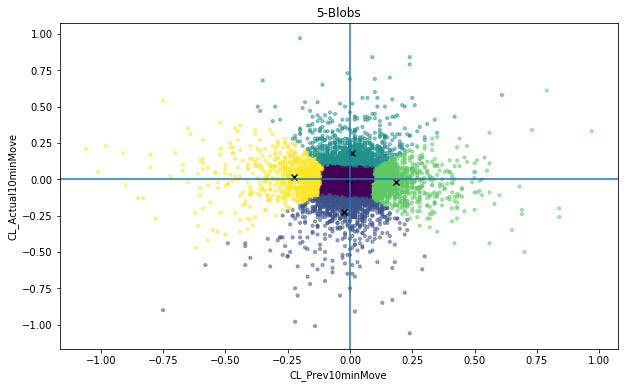

Cluster Centers: 
 [[-0.31453265  0.01322663]
 [-0.00153423  0.17461841]
 [ 0.20807153 -0.02035063]
 [-0.03873373 -0.23050888]
 [-0.00631833 -0.00377147]] 



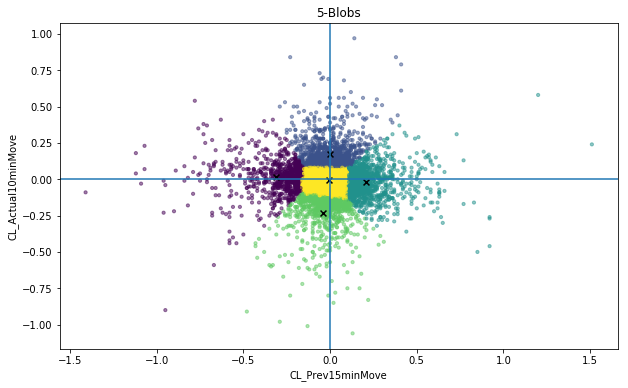

Cluster Centers: 
 [[ 0.33619946 -0.00089847]
 [-0.66109375 -0.0009375 ]
 [-0.03508035 -0.22605686]
 [-0.16408038  0.02271798]
 [ 0.03345294  0.01146635]] 



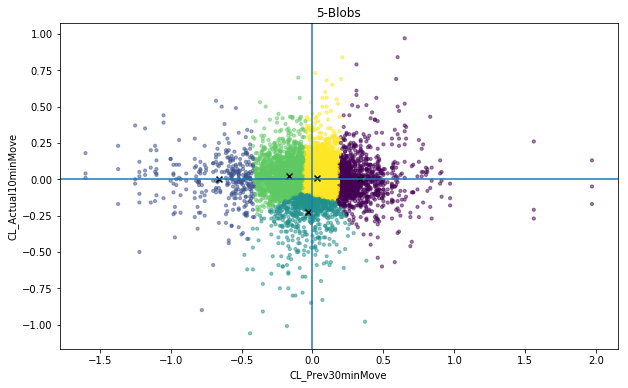

Cluster Centers: 
 [[ 4.95564519e-03 -1.70295699e-03]
 [-2.55833334e-01 -3.27073550e-03]
 [ 8.67756654e-01 -1.23193919e-02]
 [ 2.44183188e-01  1.82394941e-04]
 [-7.84589802e-01 -2.92682903e-03]] 



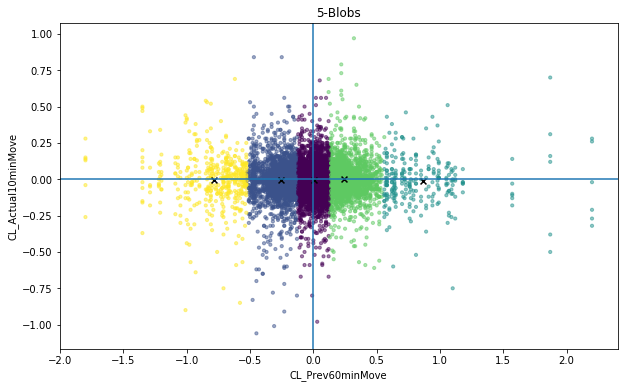

Cluster Centers: 
 [[ 7.19610551e+03 -5.65361639e-03]
 [ 3.07406426e+04 -1.09609613e-02]
 [ 5.83544091e+04 -2.51515140e-02]
 [ 1.60007347e+03 -1.76504310e-04]
 [ 1.59596325e+04 -1.13345514e-03]] 



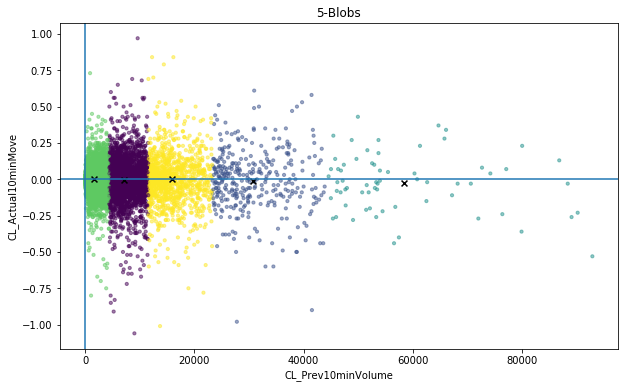

Cluster Centers: 
 [[ 7.19610551e+03 -5.65361639e-03]
 [ 3.07406426e+04 -1.09609613e-02]
 [ 5.83544091e+04 -2.51515140e-02]
 [ 1.60007347e+03 -1.76504310e-04]
 [ 1.59596325e+04 -1.13345514e-03]] 



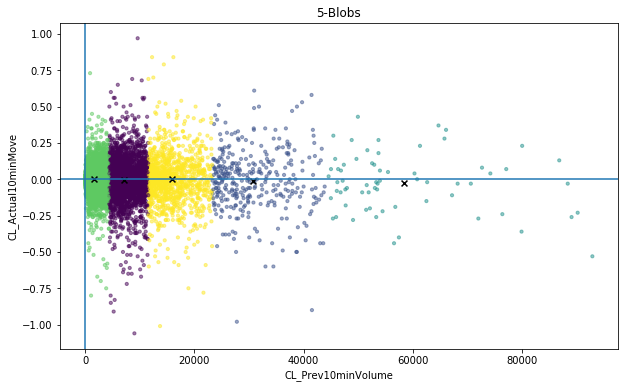

Cluster Centers: 
 [[ 2.01974250e+04  7.61271360e-04]
 [ 9.51556577e+03 -7.42953017e-03]
 [ 3.90621776e+04 -7.32456147e-03]
 [ 2.22680472e+03  3.95588472e-05]
 [ 7.32890000e+04 -9.99999979e-03]] 



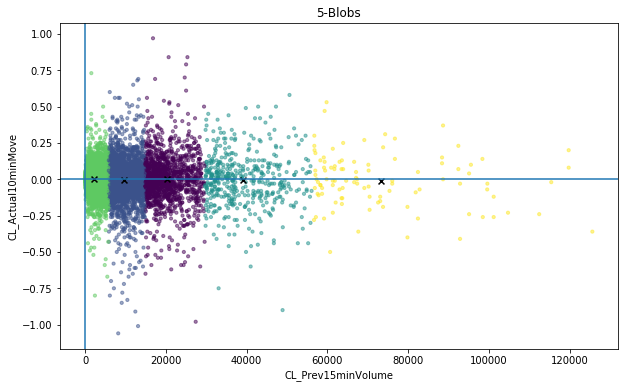

Cluster Centers: 
 [[ 1.85889977e+04 -4.94222513e-03]
 [ 4.47905642e+03  1.95861034e-04]
 [ 7.58172071e+04 -3.49112435e-03]
 [ 3.82507647e+04 -7.53887749e-03]
 [ 1.36080152e+05  1.18181822e-02]] 



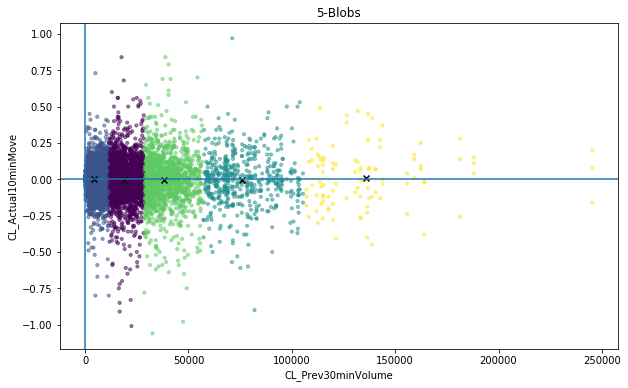

Cluster Centers: 
 [[ 7.66846208e+04 -7.31944433e-03]
 [ 9.19201108e+03  2.49065984e-04]
 [ 3.79800648e+04 -4.76190472e-03]
 [ 1.39749538e+05 -1.04059829e-02]
 [ 2.25313167e+05  2.27777777e-02]] 



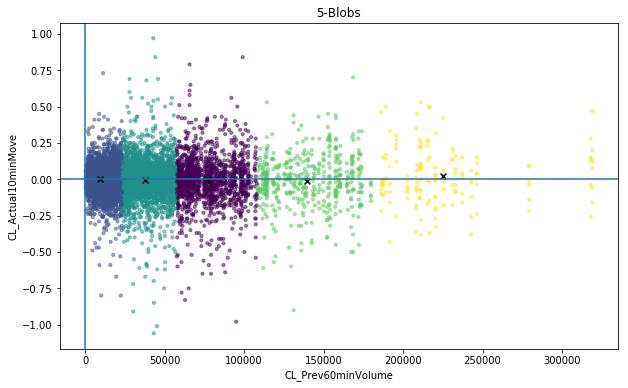

Cluster Centers: 
 [[ 0.0413872   0.01742697]
 [ 0.06641375 -0.08687989]
 [ 0.09488475  0.19507092]
 [ 0.29768553 -0.01542138]
 [ 0.10886154 -0.36236923]] 



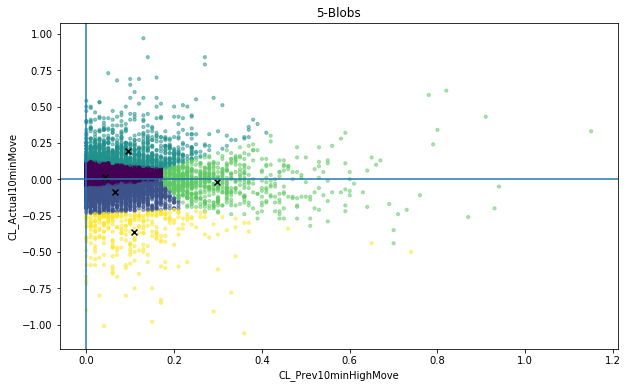

Cluster Centers: 
 [[ 0.0413872   0.01742697]
 [ 0.06641375 -0.08687989]
 [ 0.09488475  0.19507092]
 [ 0.29768553 -0.01542138]
 [ 0.10886154 -0.36236923]] 



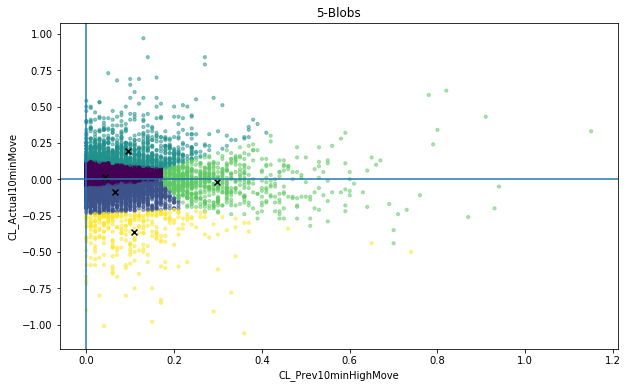

Cluster Centers: 
 [[ 0.038553    0.00054626]
 [ 0.17325066 -0.01645261]
 [ 0.46560773 -0.03541436]
 [ 0.11228374  0.19436851]
 [ 0.08737089 -0.24008216]] 



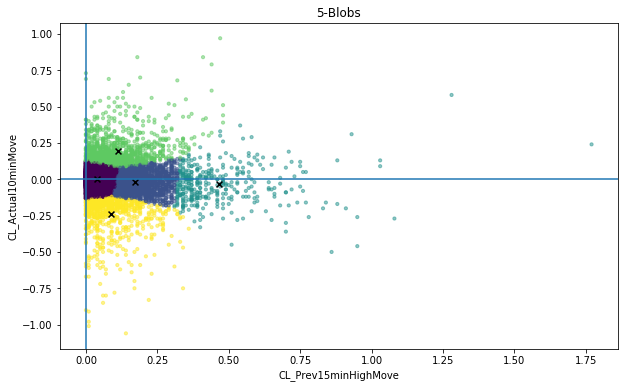

Cluster Centers: 
 [[ 0.12725106  0.17939574]
 [ 0.64119617 -0.00066986]
 [ 0.05652484 -0.00170777]
 [ 0.11270463 -0.23338078]
 [ 0.25505132 -0.01083891]] 



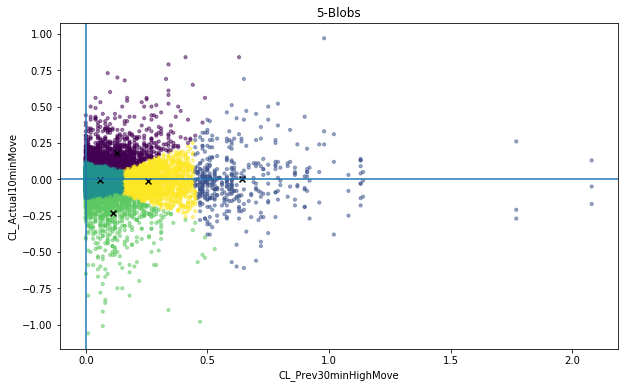

Cluster Centers: 
 [[ 1.27272728 -0.01212121]
 [ 0.06628677  0.01618445]
 [ 0.59169811 -0.00425083]
 [ 0.13296196 -0.19894928]
 [ 0.26317363  0.02240159]] 



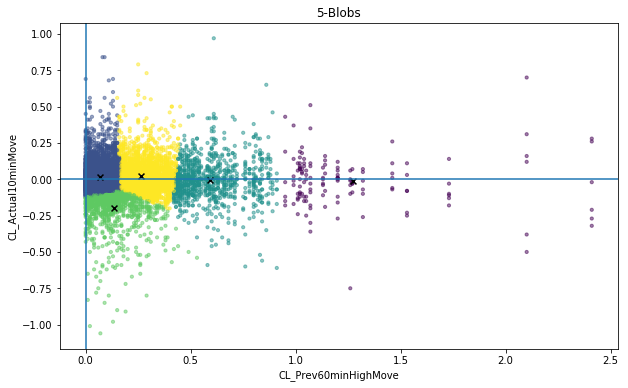

Cluster Centers: 
 [[-0.03441143 -0.00270876]
 [-0.0936785  -0.22164694]
 [-0.49596154  0.01626923]
 [-0.17380634 -0.00706733]
 [-0.09022745  0.18208627]] 



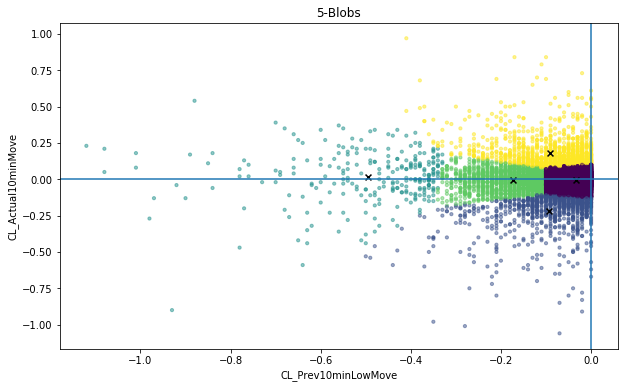

Cluster Centers: 
 [[-0.03441143 -0.00270876]
 [-0.0936785  -0.22164694]
 [-0.49596154  0.01626923]
 [-0.17380634 -0.00706733]
 [-0.09022745  0.18208627]] 



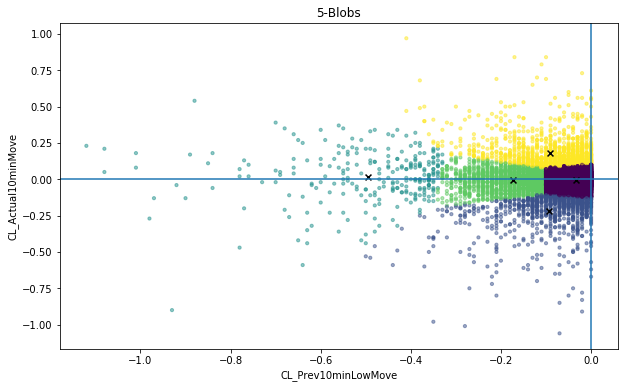

Cluster Centers: 
 [[-6.01080137e-01 -5.57490809e-04]
 [-4.18762767e-02 -2.84108969e-03]
 [-1.12550201e-01 -2.20552208e-01]
 [-2.10166061e-01 -2.80228341e-03]
 [-1.00948845e-01  1.85750825e-01]] 



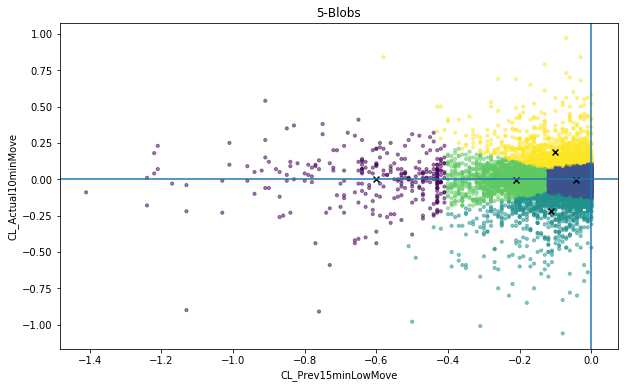

Cluster Centers: 
 [[-0.32773096  0.00632631]
 [-0.12387466  0.15463612]
 [-0.83572847 -0.00119205]
 [-0.06115095 -0.00667438]
 [-0.16046316 -0.21922105]] 



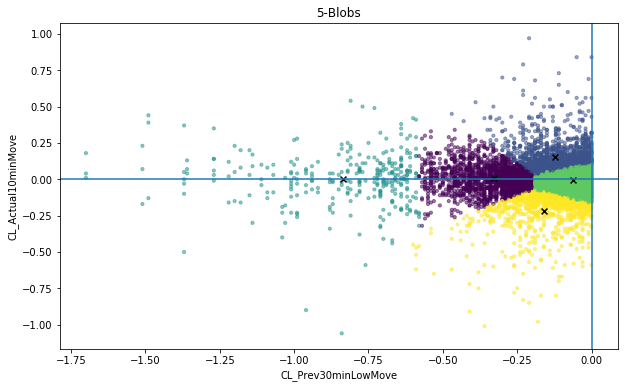

Cluster Centers: 
 [[-0.06364938  0.00723168]
 [-0.55770076  0.00413356]
 [-0.2579489   0.04276934]
 [-0.20711662 -0.19571166]
 [-1.13269231  0.01022436]] 



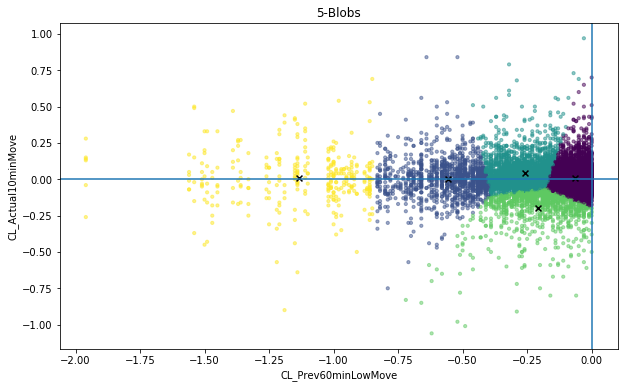

Cluster Centers: 
 [[ 0.0413872   0.01742697]
 [ 0.06641375 -0.08687989]
 [ 0.09488475  0.19507092]
 [ 0.29768553 -0.01542138]
 [ 0.10886154 -0.36236923]] 



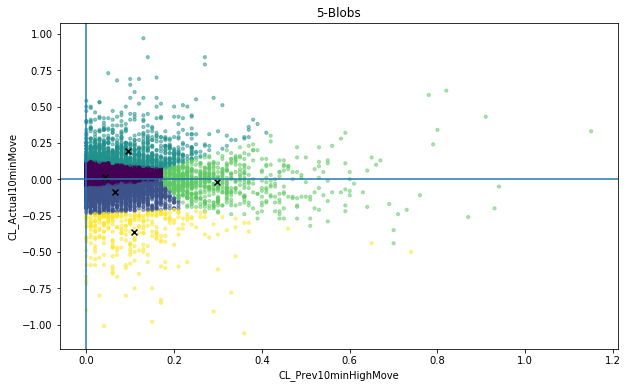

Cluster Centers: 
 [[ 0.038553    0.00054626]
 [ 0.17325066 -0.01645261]
 [ 0.46560773 -0.03541436]
 [ 0.11228374  0.19436851]
 [ 0.08737089 -0.24008216]] 



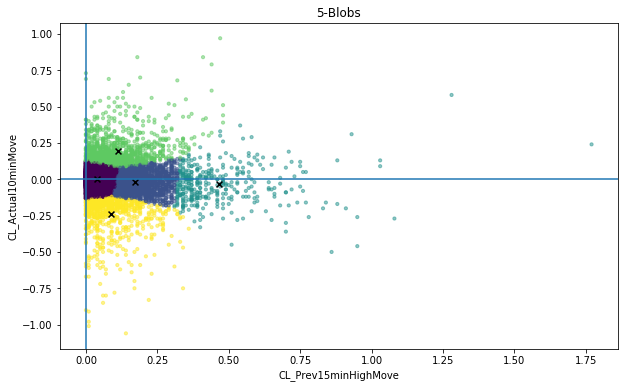

Cluster Centers: 
 [[ 0.12725106  0.17939574]
 [ 0.64119617 -0.00066986]
 [ 0.05652484 -0.00170777]
 [ 0.11270463 -0.23338078]
 [ 0.25505132 -0.01083891]] 



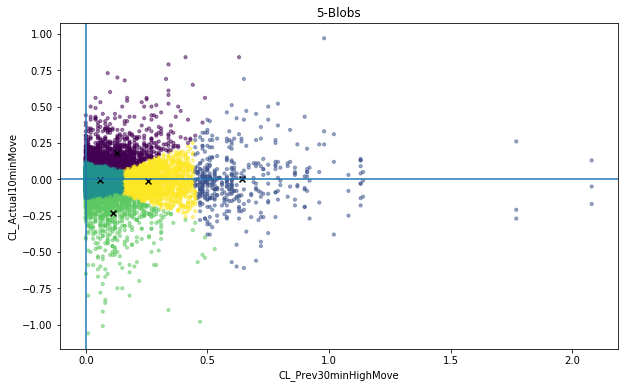

Cluster Centers: 
 [[ 1.27272728 -0.01212121]
 [ 0.06628677  0.01618445]
 [ 0.59169811 -0.00425083]
 [ 0.13296196 -0.19894928]
 [ 0.26317363  0.02240159]] 



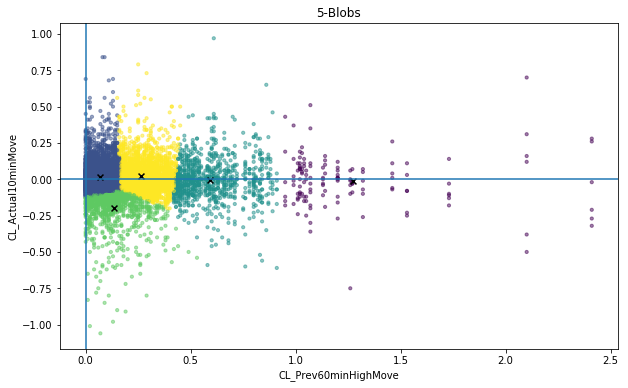

Cluster Centers: 
 [[ 7.19610551e+03 -5.65361639e-03]
 [ 3.07406426e+04 -1.09609613e-02]
 [ 5.83544091e+04 -2.51515140e-02]
 [ 1.60007347e+03 -1.76504310e-04]
 [ 1.59596325e+04 -1.13345514e-03]] 



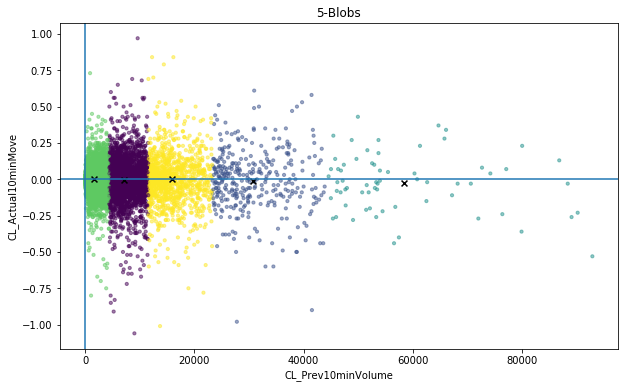

Cluster Centers: 
 [[ 7.19610551e+03 -5.65361639e-03]
 [ 3.07406426e+04 -1.09609613e-02]
 [ 5.83544091e+04 -2.51515140e-02]
 [ 1.60007347e+03 -1.76504310e-04]
 [ 1.59596325e+04 -1.13345514e-03]] 



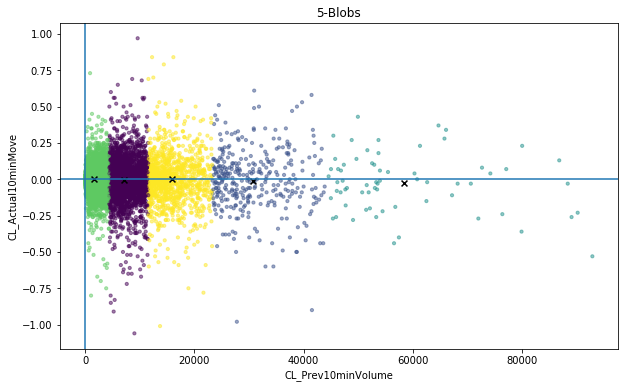

Cluster Centers: 
 [[ 2.01974250e+04  7.61271360e-04]
 [ 9.51556577e+03 -7.42953017e-03]
 [ 3.90621776e+04 -7.32456147e-03]
 [ 2.22680472e+03  3.95588472e-05]
 [ 7.32890000e+04 -9.99999979e-03]] 



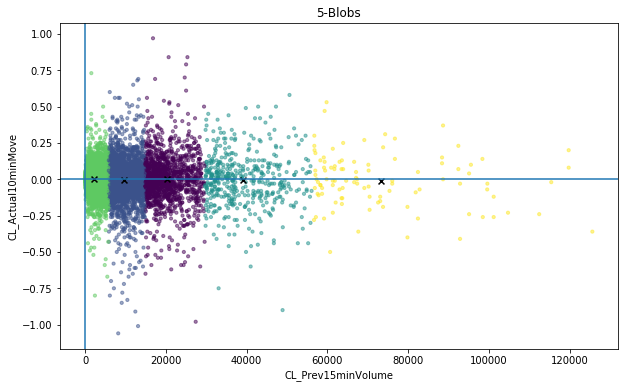

Cluster Centers: 
 [[ 1.85889977e+04 -4.94222513e-03]
 [ 4.47905642e+03  1.95861034e-04]
 [ 7.58172071e+04 -3.49112435e-03]
 [ 3.82507647e+04 -7.53887749e-03]
 [ 1.36080152e+05  1.18181822e-02]] 



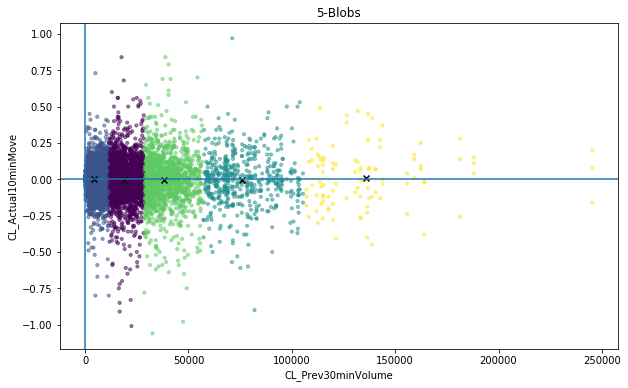

Cluster Centers: 
 [[ 7.66846208e+04 -7.31944433e-03]
 [ 9.19201108e+03  2.49065984e-04]
 [ 3.79800648e+04 -4.76190472e-03]
 [ 1.39749538e+05 -1.04059829e-02]
 [ 2.25313167e+05  2.27777777e-02]] 



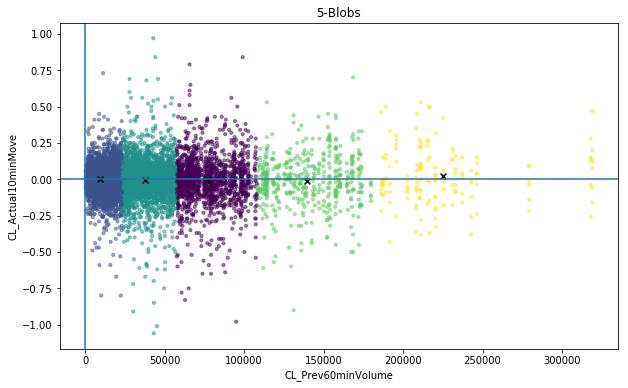

Cluster Centers: 
 [[ 0.0413872   0.01742697]
 [ 0.06641375 -0.08687989]
 [ 0.09488475  0.19507092]
 [ 0.29768553 -0.01542138]
 [ 0.10886154 -0.36236923]] 



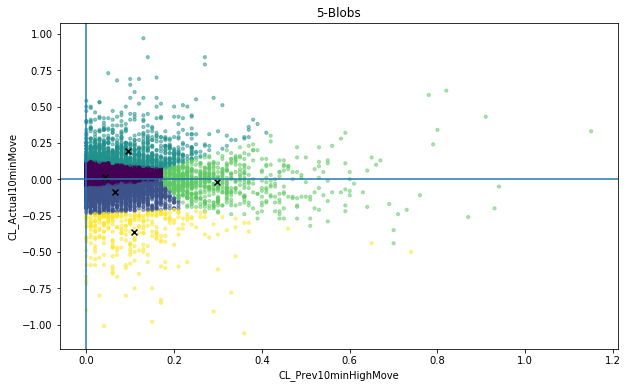

Cluster Centers: 
 [[ 0.0413872   0.01742697]
 [ 0.06641375 -0.08687989]
 [ 0.09488475  0.19507092]
 [ 0.29768553 -0.01542138]
 [ 0.10886154 -0.36236923]] 



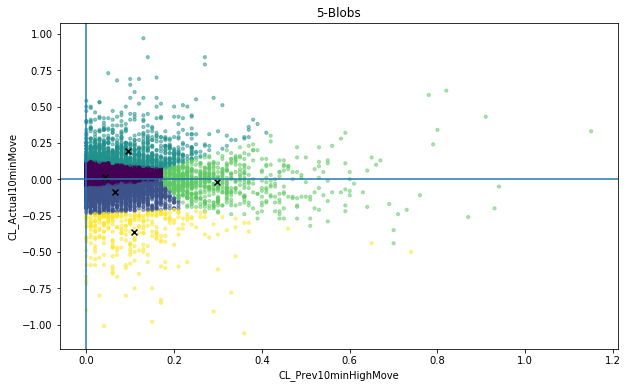

Cluster Centers: 
 [[ 0.038553    0.00054626]
 [ 0.17325066 -0.01645261]
 [ 0.46560773 -0.03541436]
 [ 0.11228374  0.19436851]
 [ 0.08737089 -0.24008216]] 



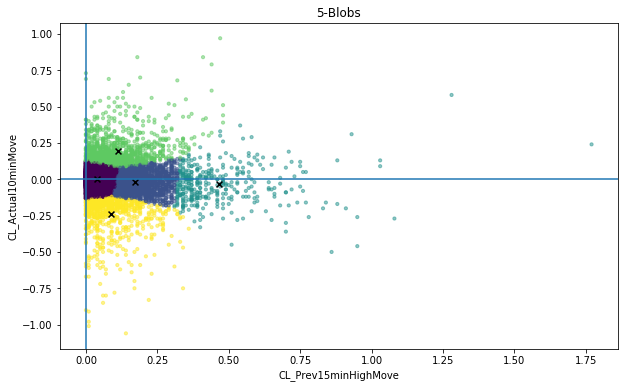

Cluster Centers: 
 [[ 0.12725106  0.17939574]
 [ 0.64119617 -0.00066986]
 [ 0.05652484 -0.00170777]
 [ 0.11270463 -0.23338078]
 [ 0.25505132 -0.01083891]] 



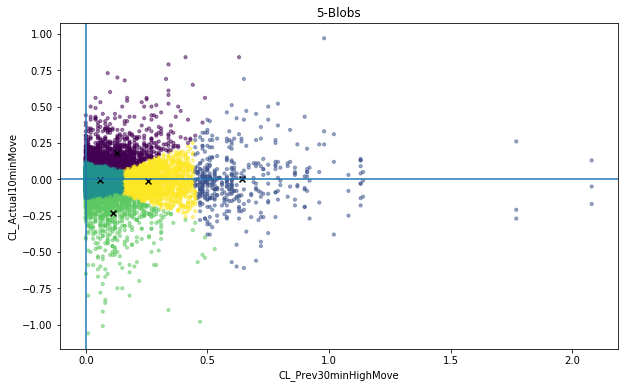

Cluster Centers: 
 [[ 1.27272728 -0.01212121]
 [ 0.06628677  0.01618445]
 [ 0.59169811 -0.00425083]
 [ 0.13296196 -0.19894928]
 [ 0.26317363  0.02240159]] 



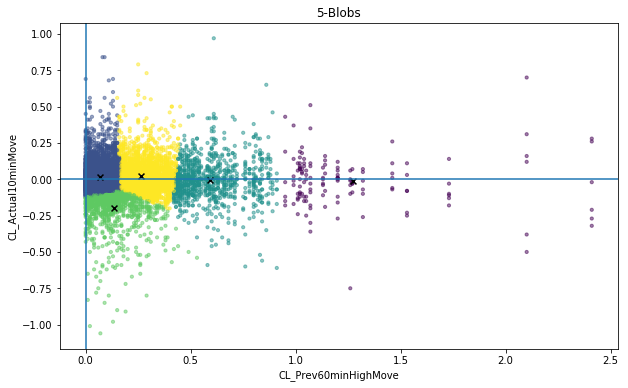

Cluster Centers: 
 [[-0.03441143 -0.00270876]
 [-0.0936785  -0.22164694]
 [-0.49596154  0.01626923]
 [-0.17380634 -0.00706733]
 [-0.09022745  0.18208627]] 



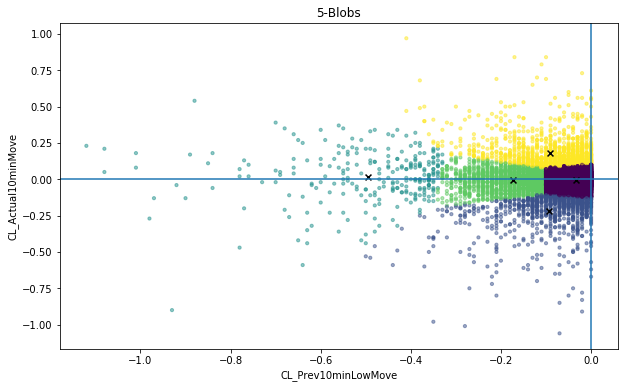

Cluster Centers: 
 [[-0.03441143 -0.00270876]
 [-0.0936785  -0.22164694]
 [-0.49596154  0.01626923]
 [-0.17380634 -0.00706733]
 [-0.09022745  0.18208627]] 



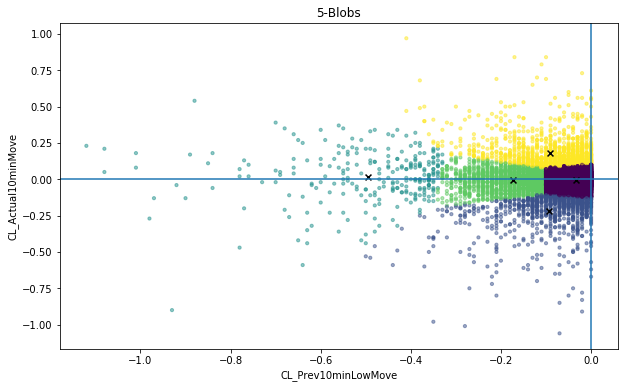

Cluster Centers: 
 [[-6.01080137e-01 -5.57490809e-04]
 [-4.18762767e-02 -2.84108969e-03]
 [-1.12550201e-01 -2.20552208e-01]
 [-2.10166061e-01 -2.80228341e-03]
 [-1.00948845e-01  1.85750825e-01]] 



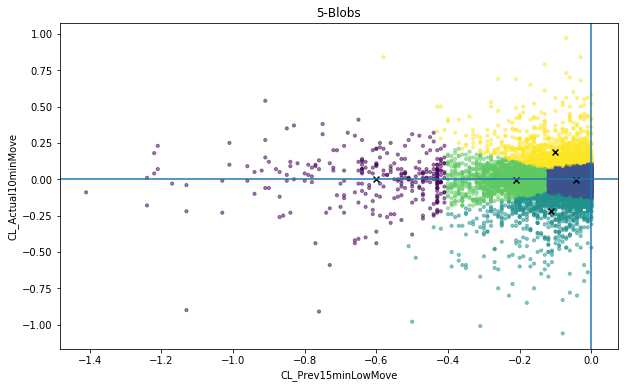

Cluster Centers: 
 [[-0.32773096  0.00632631]
 [-0.12387466  0.15463612]
 [-0.83572847 -0.00119205]
 [-0.06115095 -0.00667438]
 [-0.16046316 -0.21922105]] 



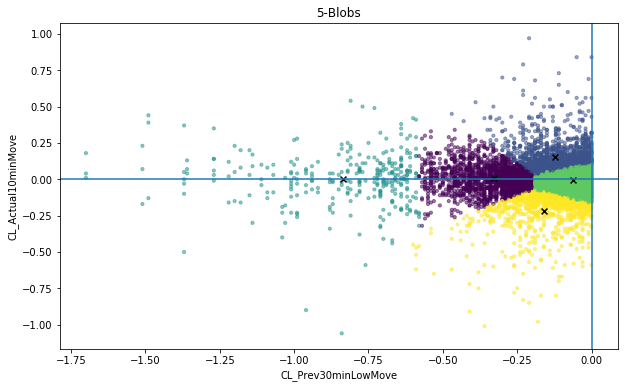

Cluster Centers: 
 [[-0.06364938  0.00723168]
 [-0.55770076  0.00413356]
 [-0.2579489   0.04276934]
 [-0.20711662 -0.19571166]
 [-1.13269231  0.01022436]] 



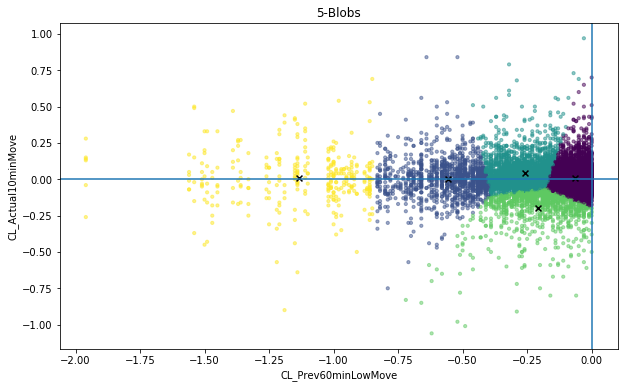

Cluster Centers: 
 [[-0.03441143 -0.00270876]
 [-0.0936785  -0.22164694]
 [-0.49596154  0.01626923]
 [-0.17380634 -0.00706733]
 [-0.09022745  0.18208627]] 



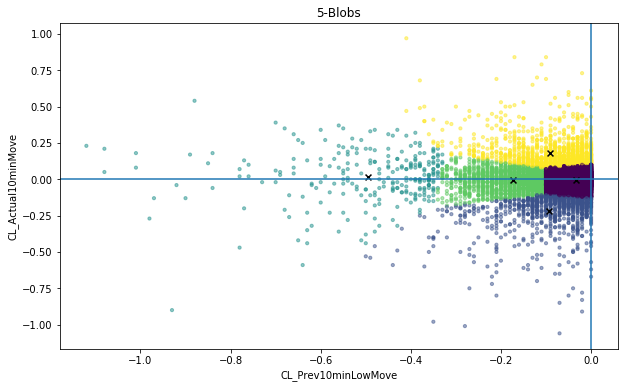

Cluster Centers: 
 [[-6.01080137e-01 -5.57490809e-04]
 [-4.18762767e-02 -2.84108969e-03]
 [-1.12550201e-01 -2.20552208e-01]
 [-2.10166061e-01 -2.80228341e-03]
 [-1.00948845e-01  1.85750825e-01]] 



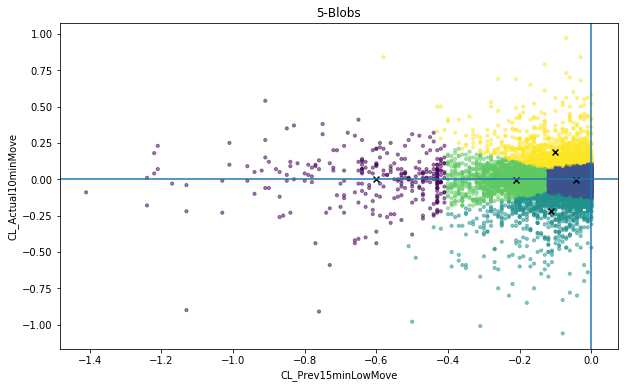

Cluster Centers: 
 [[-0.32773096  0.00632631]
 [-0.12387466  0.15463612]
 [-0.83572847 -0.00119205]
 [-0.06115095 -0.00667438]
 [-0.16046316 -0.21922105]] 



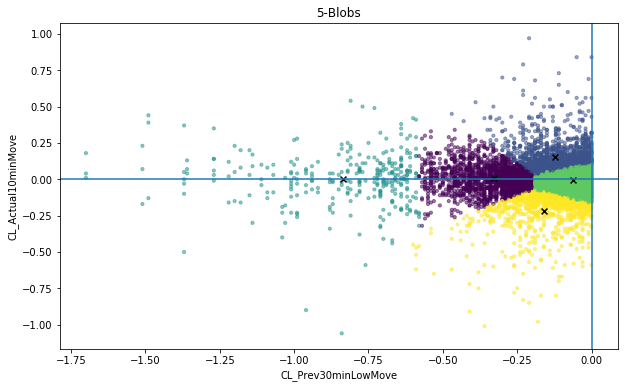

Cluster Centers: 
 [[-0.06364938  0.00723168]
 [-0.55770076  0.00413356]
 [-0.2579489   0.04276934]
 [-0.20711662 -0.19571166]
 [-1.13269231  0.01022436]] 



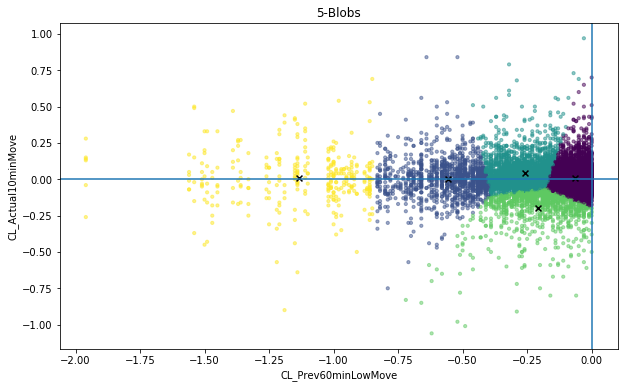

Cluster Centers: 
 [[ 7.19610551e+03 -5.65361639e-03]
 [ 3.07406426e+04 -1.09609613e-02]
 [ 5.83544091e+04 -2.51515140e-02]
 [ 1.60007347e+03 -1.76504310e-04]
 [ 1.59596325e+04 -1.13345514e-03]] 



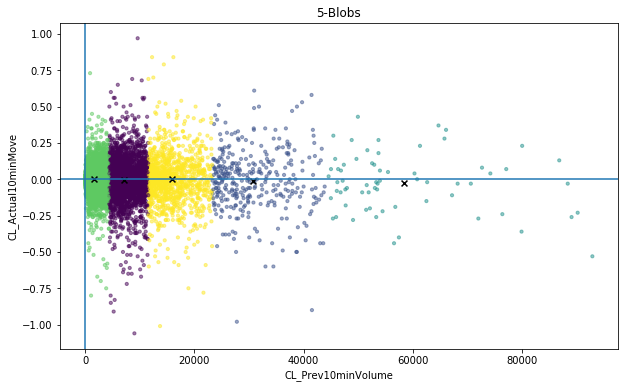

Cluster Centers: 
 [[ 7.19610551e+03 -5.65361639e-03]
 [ 3.07406426e+04 -1.09609613e-02]
 [ 5.83544091e+04 -2.51515140e-02]
 [ 1.60007347e+03 -1.76504310e-04]
 [ 1.59596325e+04 -1.13345514e-03]] 



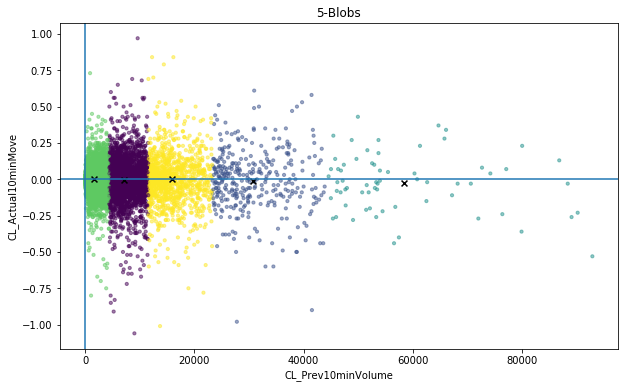

Cluster Centers: 
 [[ 2.01974250e+04  7.61271360e-04]
 [ 9.51556577e+03 -7.42953017e-03]
 [ 3.90621776e+04 -7.32456147e-03]
 [ 2.22680472e+03  3.95588472e-05]
 [ 7.32890000e+04 -9.99999979e-03]] 



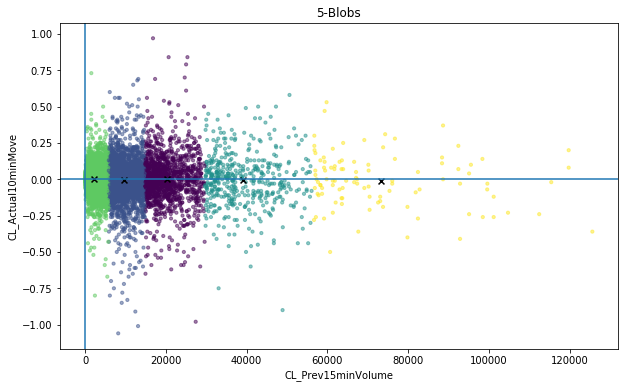

Cluster Centers: 
 [[ 1.85889977e+04 -4.94222513e-03]
 [ 4.47905642e+03  1.95861034e-04]
 [ 7.58172071e+04 -3.49112435e-03]
 [ 3.82507647e+04 -7.53887749e-03]
 [ 1.36080152e+05  1.18181822e-02]] 



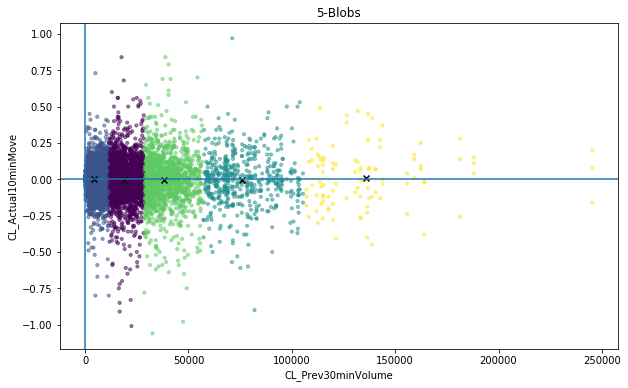

Cluster Centers: 
 [[ 7.66846208e+04 -7.31944433e-03]
 [ 9.19201108e+03  2.49065984e-04]
 [ 3.79800648e+04 -4.76190472e-03]
 [ 1.39749538e+05 -1.04059829e-02]
 [ 2.25313167e+05  2.27777777e-02]] 



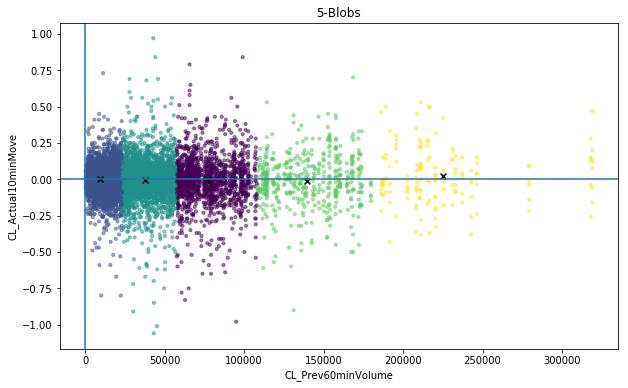

Cluster Centers: 
 [[-0.03441143 -0.00270876]
 [-0.0936785  -0.22164694]
 [-0.49596154  0.01626923]
 [-0.17380634 -0.00706733]
 [-0.09022745  0.18208627]] 



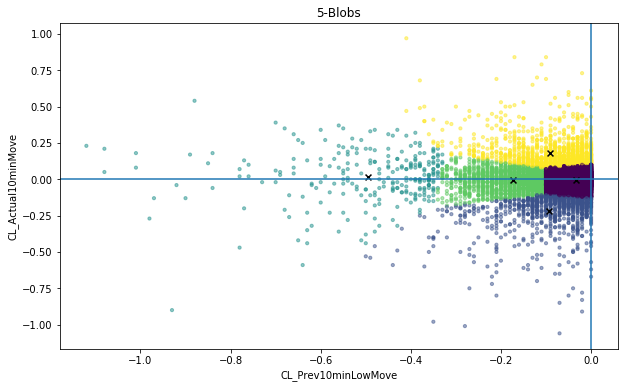

Cluster Centers: 
 [[-0.03441143 -0.00270876]
 [-0.0936785  -0.22164694]
 [-0.49596154  0.01626923]
 [-0.17380634 -0.00706733]
 [-0.09022745  0.18208627]] 



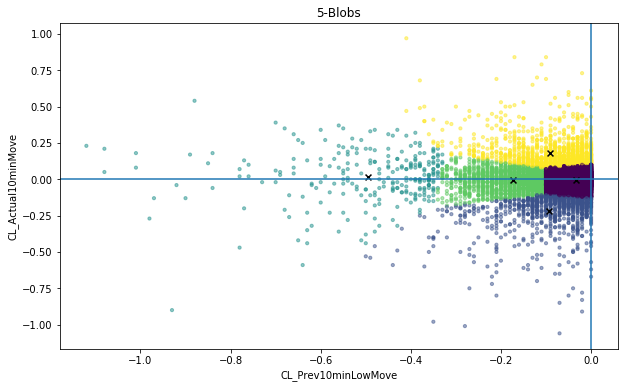

Cluster Centers: 
 [[-6.01080137e-01 -5.57490809e-04]
 [-4.18762767e-02 -2.84108969e-03]
 [-1.12550201e-01 -2.20552208e-01]
 [-2.10166061e-01 -2.80228341e-03]
 [-1.00948845e-01  1.85750825e-01]] 



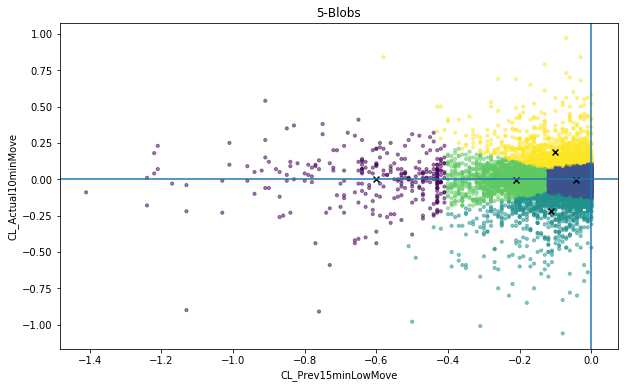

Cluster Centers: 
 [[-0.32773096  0.00632631]
 [-0.12387466  0.15463612]
 [-0.83572847 -0.00119205]
 [-0.06115095 -0.00667438]
 [-0.16046316 -0.21922105]] 



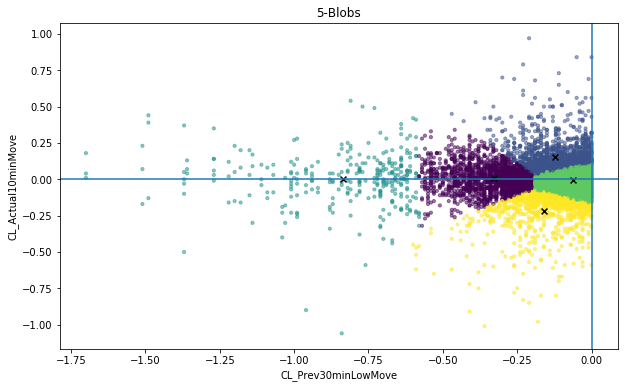

Cluster Centers: 
 [[-0.06364938  0.00723168]
 [-0.55770076  0.00413356]
 [-0.2579489   0.04276934]
 [-0.20711662 -0.19571166]
 [-1.13269231  0.01022436]] 



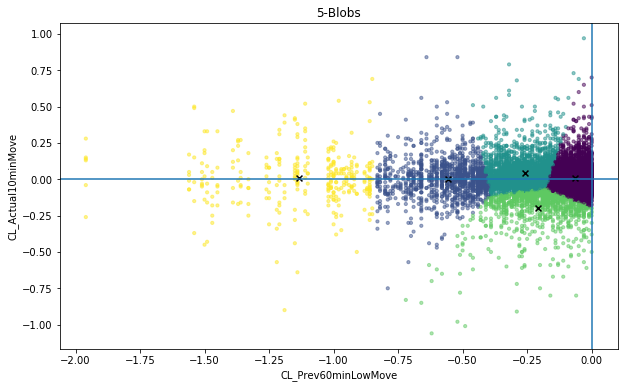

Cluster Centers: 
 [[-0.03441143 -0.00270876]
 [-0.0936785  -0.22164694]
 [-0.49596154  0.01626923]
 [-0.17380634 -0.00706733]
 [-0.09022745  0.18208627]] 



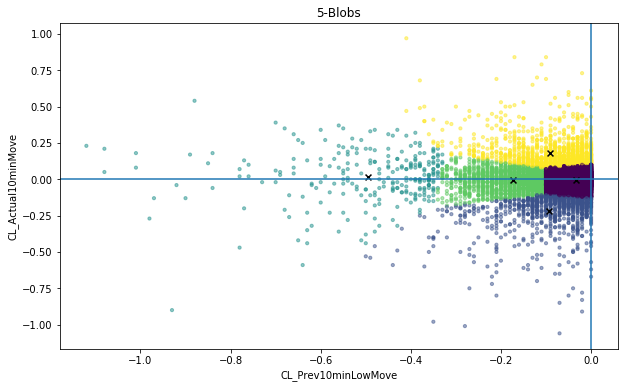

Cluster Centers: 
 [[-0.03441143 -0.00270876]
 [-0.0936785  -0.22164694]
 [-0.49596154  0.01626923]
 [-0.17380634 -0.00706733]
 [-0.09022745  0.18208627]] 



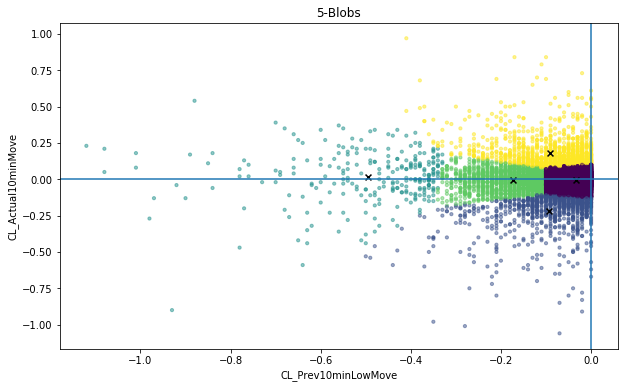

Cluster Centers: 
 [[-6.01080137e-01 -5.57490809e-04]
 [-4.18762767e-02 -2.84108969e-03]
 [-1.12550201e-01 -2.20552208e-01]
 [-2.10166061e-01 -2.80228341e-03]
 [-1.00948845e-01  1.85750825e-01]] 



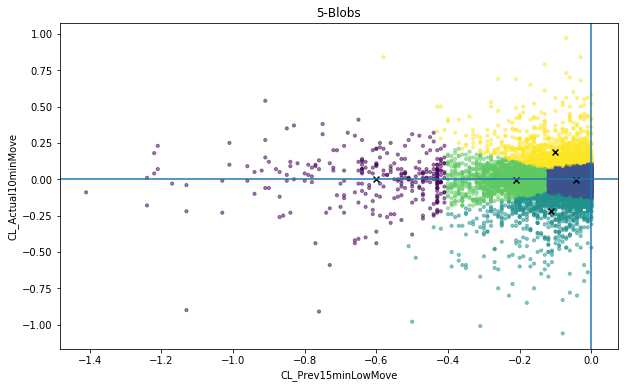

Cluster Centers: 
 [[-0.32773096  0.00632631]
 [-0.12387466  0.15463612]
 [-0.83572847 -0.00119205]
 [-0.06115095 -0.00667438]
 [-0.16046316 -0.21922105]] 



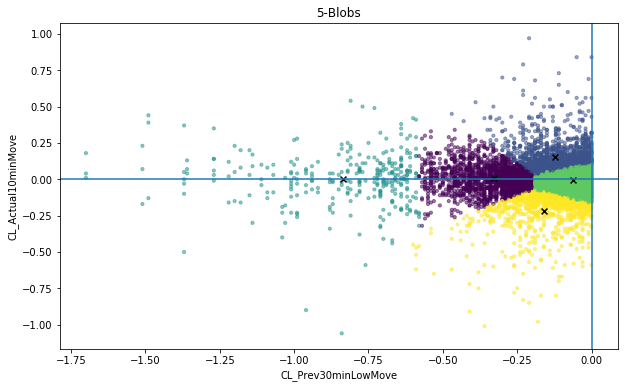

Cluster Centers: 
 [[-0.06364938  0.00723168]
 [-0.55770076  0.00413356]
 [-0.2579489   0.04276934]
 [-0.20711662 -0.19571166]
 [-1.13269231  0.01022436]] 



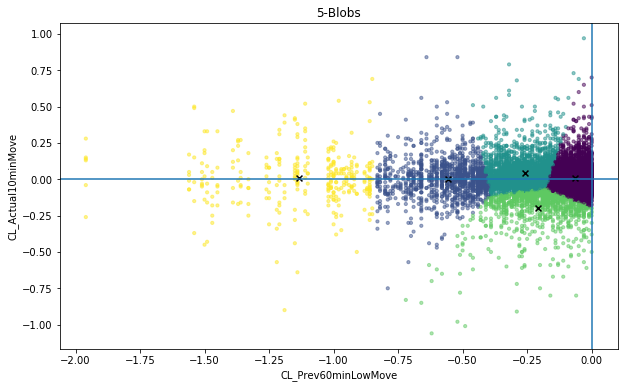

In [89]:
feature_lst = ['CL_Prev10minMove', 'CL_Prev15minMove', 'CL_Prev30minMove', 'CL_Prev60minMove',
               'CL_Prev10minVolume', 'CL_Prev10minVolume', 'CL_Prev15minVolume','CL_Prev30minVolume', 'CL_Prev60minVolume',
               'CL_Prev10minHighMove', 'CL_Prev10minHighMove', 'CL_Prev15minHighMove', 'CL_Prev30minHighMove', 'CL_Prev60minHighMove',
               'CL_Prev10minLowMove', 'CL_Prev10minLowMove', 'CL_Prev15minLowMove', 'CL_Prev30minLowMove', 'CL_Prev60minLowMove',
               
               'CL_Prev10minHighMove', 'CL_Prev15minHighMove', 'CL_Prev30minHighMove', 'CL_Prev60minHighMove',
               'CL_Prev10minVolume', 'CL_Prev10minVolume', 'CL_Prev15minVolume','CL_Prev30minVolume', 'CL_Prev60minVolume',
               'CL_Prev10minHighMove', 'CL_Prev10minHighMove', 'CL_Prev15minHighMove', 'CL_Prev30minHighMove', 'CL_Prev60minHighMove',
               'CL_Prev10minLowMove', 'CL_Prev10minLowMove', 'CL_Prev15minLowMove', 'CL_Prev30minLowMove', 'CL_Prev60minLowMove',
        
               'CL_Prev10minLowMove', 'CL_Prev15minLowMove', 'CL_Prev30minLowMove', 'CL_Prev60minLowMove',
               'CL_Prev10minVolume', 'CL_Prev10minVolume', 'CL_Prev15minVolume','CL_Prev30minVolume', 'CL_Prev60minVolume',
               'CL_Prev10minLowMove', 'CL_Prev10minLowMove', 'CL_Prev15minLowMove', 'CL_Prev30minLowMove', 'CL_Prev60minLowMove',
               'CL_Prev10minLowMove', 'CL_Prev10minLowMove', 'CL_Prev15minLowMove', 'CL_Prev30minLowMove', 'CL_Prev60minLowMove']

for feature in feature_lst:
    plot_kmeans_blobs(df, feature, 'CL_Actual10minMove', 5)

In [110]:
df2 = pd.read_csv('/home/melgazar9/Trading/TD/Data/CL/CL_Training_Data_TD/CL_10min/CL_10min_FULL_2019-01-19.csv')

In [111]:
df2.set_index('Datetime')[[i for i in df2.columns if i == 'Prev10minMove' or 'Pct' in i]]

Prev10minMove  Prev10minClose_PctChange  \
Datetime                                                       
2018-03-02 20:00:00           0.04                  0.000817   
2018-03-02 20:10:00           0.01                  0.000163   
2018-03-02 20:20:00           0.03                  0.000490   
2018-03-02 20:30:00           0.07                  0.001142   
2018-03-02 20:40:00           0.08                  0.001304   
2018-03-02 20:50:00          -0.01                 -0.000163   
2018-03-02 21:00:00           0.00                  0.000163   
2018-03-02 21:10:00          -0.05                 -0.000651   
2018-03-02 21:20:00           0.04                  0.000489   
2018-03-02 21:30:00           0.01                  0.000000   
2018-03-02 21:40:00           0.12                  0.001954   
2018-03-02 21:50:00           0.00                 -0.000162   
2018-03-02 22:00:00          -0.07                 -0.001300   
2018-03-05 02:00:00          -0.09                  0.001790   
2018-03-05 02:10:00           0.03                  0.000487   
2018-03-05 02:20:00          -0.01                 -0.000162   
2018-03-05 02:30:00           0.01                  0.000162   
2018-03-05 02:40:00          -0.07                 -0.001137   
2018-03-05 02:50:00          -0.04                 -0.000488   
2018-03-05 03:00:00          -0.01                 -0.000163   
2018-03-05 03:10:00          -0.02                 -0.000325   
2018-03-05 03:20:00           0.03                  0.000325   
2018-03-05 03:30:00           0.05                  0.000813   
2018-03-05 03:40:00           0.01                  0.000000   
2018-03-05 03:50:00          -0.02                 -0.000163   
2018-03-05 04:00:00           0.00                  0.000163   
2018-03-05 04:10:00           0.03                  0.000488   
2018-03-05 04:20:00          -0.04                 -0.000650   
2018-03-05 04:30:00          -0.02                 -0.000163   
2018-03-05 04:40:00           0.00                 -0.000163   
...                            ...                       ...   
2019-01-04 17:00:00           0.06                  0.001245   
2019-01-04 17:10:00          -0.25                 -0.005181   
2019-01-04 17:20:00           0.00                  0.000000   
2019-01-04 17:30:00          -0.06                 -0.001250   
2019-01-04 17:40:00          -0.17                 -0.003338   
2019-01-04 17:50:00           0.18                  0.003767   
2019-01-04 18:00:00          -0.06                 -0.001043   
2019-01-04 18:10:00           0.01                  0.000209   
2019-01-04 18:20:00           0.15                  0.003130   
2019-01-04 18:30:00           0.05                  0.001248   
2019-01-04 18:40:00          -0.24                 -0.004986   
2019-01-04 18:50:00           0.00                  0.000000   
2019-01-04 19:00:00           0.00                  0.000000   
2019-01-04 19:10:00           0.06                  0.001462   
2019-01-04 19:20:00           0.13                  0.002711   
2019-01-04 19:30:00          -0.12                 -0.002495   
2019-01-04 19:40:00           0.09                  0.001876   
2019-01-04 19:50:00           0.01                  0.000208   
2019-01-04 20:00:00          -0.02                 -0.000416   
2019-01-04 20:10:00           0.04                  0.000832   
2019-01-04 20:20:00           0.08                  0.001664   
2019-01-04 20:30:00          -0.02                 -0.000208   
2019-01-04 20:40:00           0.01                  0.000000   
2019-01-04 20:50:00           0.01                  0.000208   
2019-01-04 21:00:00           0.05                  0.001038   
2019-01-04 21:10:00          -0.03                 -0.000830   
2019-01-04 21:20:00           0.02                  0.000415   
2019-01-04 21:30:00           0.07                  0.001245   
2019-01-04 21:40:00           0.01                  0.000207   
2019-01-04 21:50:00           0.04                  0